# Changes:
1. Use Unet with Squeeze and Excitation blocks

## Install required packages if running on google colab

In [52]:
try:
    import torch
except:
    !pip install torch torchvision
    !pip install imageio
    !pip install Augmentor
    !git clone https://github.com/allen-q/salt_oil.git
    !git clone https://github.com/allen-q/salt_net.git

[autoreload of salt_func_lib failed: Traceback (most recent call last):
  File "c:\users\allen\anaconda3\envs\ds\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\users\allen\anaconda3\envs\ds\lib\site-packages\IPython\extensions\autoreload.py", line 368, in superreload
    module = reload(module)
  File "c:\users\allen\anaconda3\envs\ds\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "c:\users\allen\anaconda3\envs\ds\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\work\code\repos\sa

In [53]:
cd salt_oil

[WinError 2] The system cannot find the file specified: 'salt_oil'
C:\work\code\repos\salt_oil


## Import required libs

In [54]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle
from salt_func_lib import *
from torchvision import transforms, utils
from skimage import io, transform
import datetime as dt
import sys
from optparse import OptionParser
import torch.backends.cudnn as cudnn
from torch import optim
from torch.optim import lr_scheduler
import copy
from io import BytesIO
import Augmentor
from Augmentor.Operations import *
import random
import PIL
import cv2 as cv
% matplotlib inline
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Unet Modules

In [55]:
from pytorch_unet.eval import eval_net
from pytorch_unet.unet import UNet
from pytorch_unet.unet.unet_parts import *
from pytorch_unet.unet.resnet import *
from pytorch_unet.utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch

In [56]:
## Setup data type based on whether GPU is enabled

In [57]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!
else:    
    dtype = torch.FloatTensor

In [58]:
print(f'Data Type set to: {dtype}')

Data Type set to: <class 'torch.FloatTensor'>


## Create Global Variables

In [59]:
def init_global_variables():
    """initialize global variables such as db connection, logger etc."""
    global log
    log = get_logger('SaltNet')

In [60]:
init_global_variables()

In [61]:
def adjust_brightness(img, alpha=None, beta=None):
    if alpha is None:
        # get a random num from 0.75 to 1.25
        alpha = (random.random()/2)+0.75
    if beta is None:
        # get a random num from -40 to 40
        beta = round((random.random()-0.5)*80)
    #print(f'a:{alpha}, b:{beta}')
    img_new = cv.convertScaleAbs(img, alpha=alpha, beta=beta)
    return img_new.reshape(img.shape)

In [62]:
class SaltDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, np_img, np_mask, df_depth, mean_img, out_size=101, 
                 out_ch=1, transform=None, random_brightness=0):
        """
        Args:
            data_dir (string): Path to the image files.
            train (bool): Load train or test data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.np_img = np_img
        self.np_mask = np_mask.clip(0,1)
        self.df_depth = df_depth
        self.mean_img = mean_img
        self.out_size = out_size
        self.out_ch = out_ch
        self.transform = transform
        self.random_brightness = random_brightness

    def __len__(self):
        return len(self.np_img)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()
            
        X = self.np_img[idx]
        #X = X - self.mean_img

        if self.np_mask is None:
            y = np.zeros((101,101,1))
        else:
            y = self.np_mask[idx]

        if self.transform:
            img_in = PIL.Image.fromarray(np.c_[np.tile(X, 2), y*255])
            #img_in = PIL.Image.fromarray(np.tile(y, 3)*255)
            transformed = np.array(self.transform(img_in))
            #X = np.clip(transformed[:,:,0:1]/255, 0., 1.) - self.mean_img
            X = transformed[:,:,0:1]
            y = np.clip(transformed[:,:,2:3]/255, 0., 1.)
            
        if self.random_brightness > random.random():            
            X = adjust_brightness(X)
            X = np.clip(X/255, 0., 1.) - self.mean_img
        else:
            X = np.clip(X/255, 0., 1.) - self.mean_img            
        #from boxx import g
        #g()
        X = np.moveaxis(X, -1,0)

        pad_size = self.out_size - X.shape[2]
        pad_first = pad_size//2
        pad_last = pad_size - pad_first
        X = np.pad(X, [(0, 0),(pad_first, pad_last), (pad_first, pad_last)], mode='reflect')

        d = self.df_depth.iloc[idx,0]

        X = torch.from_numpy(X).float().type(dtype)
        X = X.repeat(self.out_ch,1,1)
        y = transform.resize(y, (101, 101), mode='constant', preserve_range=True)
        y = torch.from_numpy(y).float().squeeze().type(dtype)

        return (X,y,d,idx)

In [63]:
class Pipeline_Salt(Augmentor.Pipeline):
    def __init__(self, source_directory=None, output_directory="output", min_mask_ratio=0., save_format=None):
        super(Pipeline_Salt, self).__init__(source_directory, output_directory, save_format)
        self.min_mask_ratio = min_mask_ratio

    def torch_transform(self):
        """
        Returns the pipeline as a function that can be used with torchvision.

        .. code-block:: python

            >>> import Augmentor
            >>> import torchvision
            >>> p = Augmentor.Pipeline()
            >>> p.rotate(probability=0.7, max_left_rotate=10, max_right_rotate=10)
            >>> p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
            >>> transforms = torchvision.transforms.Compose([
            >>>     p.torch_transform(),
            >>>     torchvision.transforms.ToTensor(),
            >>> ])

        :return: The pipeline as a function.
        """
        def _transform(image):
            for operation in self.operations:
                r = round(random.uniform(0, 1), 1)
                if r <= operation.probability:

                    if not isinstance(image, list):
                        image = [image]                        
                    #print(type(operation))
                    #print(np.array(image[0]).shape)                        
                    if isinstance(operation, (Crop, CropPercentage)):
                        image = _min_mask_crop(image, operation, min_mask_ratio=self.min_mask_ratio)
                    else:
                        image = operation.perform_operation(image)[0]

            return image
        def _min_mask_crop(image, operation, min_mask_ratio=0.):
            '''Crop a image with the mask area not less than min_mask_ratio*original mask area.'''
            img_np = np.array(image[0])
            mask_in = img_np[:,:,2]
            mask_in_pct = (mask_in>0).sum()/mask_in.size
            for i in range(10):                    
                img_out = operation.perform_operation(image)[0]
                mask_out = np.array(img_out)[:,:,2]
                mask_out_pct = (mask_out>0).sum()/mask_out.size
                #print(mask_out_pct)
                if mask_out_pct >= min_mask_ratio*mask_in_pct:
                    break
            #print(f'min_mask_ratio:{min_mask_ratio} in pct: {mask_in_pct}, out pct: {mask_out_pct}')
            return img_out
            
        return _transform

## Prepare Data

### Load train and test data from npy files or from raw images if npy files not exist.

In [64]:
np_train_all, np_train_all_mask, X_test, misc_data = load_all_data()

Try loading data from npy and pickle files...
Data loaded.


### Calculate number of mask pixels per image

In [65]:
df_train_mask = pd.DataFrame((np_train_all_mask/255).sum((1,2,3)), columns=['mask_pix'])

df_train_mask.mask_pix = df_train_mask.mask_pix.round(-2)

mask_pix_bins = df_train_mask.mask_pix.sort_values().unique()
# Due to zooming and crop, under-sample all black and all white masks, over-sample images with small mask areas.
mask_pix_bin_weights = ([1.] + np.r_[2:1:102j].tolist() + [0.2])
mask_pix_bin_weights = dict(zip(mask_pix_bins, mask_pix_bin_weights))

train_all_sample_weight = df_train_mask.mask_pix.map(mask_pix_bin_weights)

In [66]:
#np.log10(df_train_mask.mask_pix.div(100).add(10))

### Remove black images

In [67]:
#black_img_ids = (np_train_all.max((1,2,3))==0)

#np_train_all = np_train_all[~black_img_ids]
#np_train_all_mask = np_train_all_mask[~black_img_ids]

In [68]:
np_train_all.shape

(4000, 101, 101, 1)

### Remove images with all black masks

In [69]:
#black_mask_ids = (np_train_all_mask.max((1,2,3))==0)
#np_train_all = np_train_all[~black_mask_ids]
#np_train_all_mask = np_train_all_mask[~black_mask_ids]

### Train Val data split

In [70]:
#np_train_all = np.clip(np_train_all/255, 0, 1)
#X_test = np.clip(X_test/255, 0, 1)

In [71]:
X_train_ids, X_val_ids = (
    train_test_split(df_train_mask.index.tolist(), 
                     test_size=0.20,
                     stratify = df_train_mask.mask_pix,
                     random_state=0)
)

In [72]:
with open('./data/df_train_img_iou.pickle', 'rb') as f:
    df_train_img_iou = pickle.load(f)

train_hard_img_id= (
    [misc_data['np_train_all_ids'].index(e) for e in df_train_img_iou.loc[df_train_img_iou.type=='HARD'].id]
)

#X_train_ids = np.setdiff1d(X_train_ids, train_hard_img_id)

In [73]:
X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
#X_train_mean_img = X_train.mean(0).astype(np.float32)
#X_train_mean_img = X_train.mean((0,1,2)).astype(np.float32)
X_train_mean_img = np.clip(np_train_all/255, 0, 1).mean((0,1,2)).astype(np.float32)

all_data = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val,
    'X_test': X_test,
    'X_train_mean_img': np.zeros_like(X_train_mean_img)
}

In [74]:
train_sample_weight = train_all_sample_weight[X_train_ids]

In [75]:
X_train_mean_img = np.zeros_like(X_train_mean_img)

In [76]:
X_train_mean_img

array([0.], dtype=float32)

In [77]:
X_train.shape

(3200, 101, 101, 1)

In [78]:
y_train.shape

(3200, 101, 101, 1)

In [79]:
depth_train.shape

(3200, 1)

In [80]:
'''p = Pipeline_Salt(min_mask_ratio=0.9)
p.crop_random(probability=1, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')
img = np.c_[np.tile(X_train[469], 2), y_train[469]]
img_in = PIL.Image.fromarray(img)
tsfm = p.torch_transform()
img_out = tsfm(img_in)'''

"p = Pipeline_Salt(min_mask_ratio=0.9)\np.crop_random(probability=1, percentage_area=0.8, randomise_percentage_area=False)\np.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')\nimg = np.c_[np.tile(X_train[469], 2), y_train[469]]\nimg_in = PIL.Image.fromarray(img)\ntsfm = p.torch_transform()\nimg_out = tsfm(img_in)"

In [81]:
p = Pipeline_Salt(min_mask_ratio=0.1)
p.skew(probability=0.5, magnitude=0.2)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=5)
#p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_random(probability=0.5, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')

### Create a Train Dataloader

In [82]:
#weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_sample_weight.values, depth_train.shape[0])

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': True}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

sample = iter(dataloaders['train']).__next__()

assert sample[0].shape == torch.Size([train_data_params['batch_size'], 1, 128, 128])
assert sample[1].shape == torch.Size([train_data_params['batch_size'], 101, 101])
assert sample[2].shape == torch.Size([train_data_params['batch_size']])
assert sample[3].shape == torch.Size([train_data_params['batch_size']])

In [83]:
t = iter(train_dataLoader).__next__()

In [84]:
X_batch, y_batch, d_batch, X_id = t

4909.980392156863, 5188.31787109375


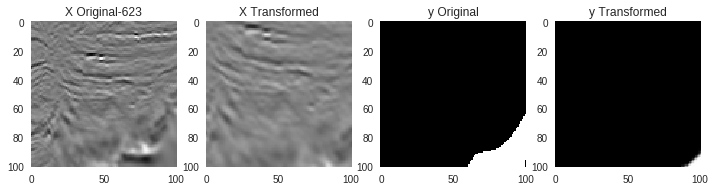

3581.4156862745094, 4736.80029296875


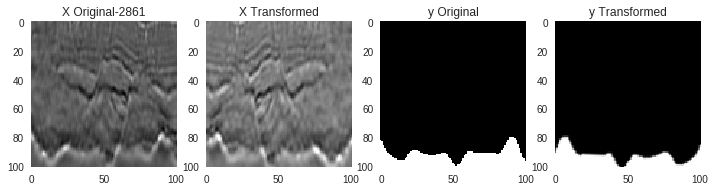

7013.623529411765, 6992.68212890625


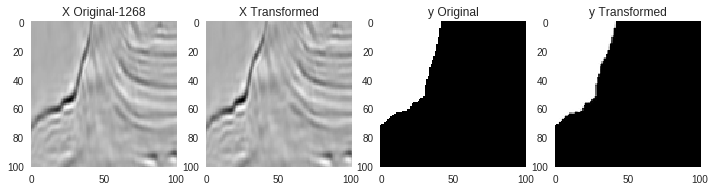

In [33]:
i = 0
for X_batch, y_batch, d_batch, X_id in dataloaders['train']:
    i+=1
    if i>3:
        break
    X_orig = X_train[X_id[0]].squeeze()/255
    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()[13:114,13:114] + X_train_mean_img.squeeze()
    y_orig = y_train[X_id[0]].squeeze()
    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
    print(f'{X_orig.sum()}, {X_tsfm.sum()}')
    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm],
                       [f'X Original-{X_id[0]}', 'X Transformed', 'y Original', 'y Transformed'])

In [45]:
torch.tensor(10.).item()

10.0

In [ ]:
def train_model(model, dataloaders, criterion1, criterion2, optimizer, scheduler, model_save_name, other_data={}, 
                num_epochs=25, print_every=2, save_model_every=None, save_log_every=None, log=get_logger('SaltNet'), loss1_weight=1, loss2_weight=0):
    #args = locals()
    #args = {k:v.shape if isinstance(v, (torch.Tensor, np.ndarray)) else v for k,v in args.items()}
    #args = {k:v.shape if isinstance(v, (torch.Tensor, np.ndarray)) else v for k,v in args.items()}
    log.info('Start Training...')
    #log.info('Passed parameters: {}'.format(args))

    start = time.time()

    if torch.cuda.is_available():
        model.cuda()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_model = None
    best_iou = 0.0
    all_losses = []
    iter_count = 0
    X_train = other_data['X_train']
    X_val = other_data['X_val']
    y_train = other_data['y_train']
    y_val = other_data['y_val']
    X_train_mean_img = other_data['X_train_mean_img']
    mask_cutoff = 0.
    epoch_loss_all = [10]
    
    for epoch in range(1, num_epochs+1):
        log.info('Epoch {}/{}'.format(epoch, num_epochs))
        log.info('-' * 20)
        if save_log_every is not None:
            if (epoch % save_log_every == 0):
                push_log_to_git()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                scheduler.step(np.mean(epoch_loss_all))
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_loss1 = []
            epoch_loss2 = []
            epoch_loss_all = []
            pred_vs_true_epoch = []

            for X_batch, y_batch, d_batch, X_id in dataloaders[phase]:
                # zero the parameter gradients
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    y_pred = model(X_batch)
                    pred_vs_true_epoch.append([y_pred, y_batch])
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':                        
                        loss_1 = loss1_weight * criterion1(y_pred, y_batch.float())      
                        if (epoch % 150 == 0):
                          loss2_weight = loss2_weight + 0.3
                        loss_2 = loss2_weight * criterion2(y_pred, y_batch.float()) 

                        #print(f'loss_pix: {loss_pix}, loss_dice:{loss_dice}')
                        loss = loss_1 + loss_2
                        #loss = loss_pix
                        all_losses.append(loss.item())
                        epoch_loss1.append(loss_1.item())
                        epoch_loss2.append(loss_2.item())
                        epoch_loss_all.append(loss_1.item() + loss_2.item())
                        loss.backward()
                        optimizer.step()                        
                        iter_count += 1
                if (phase == 'train') & (iter_count % print_every == 0):
                    iou_batch = calc_mean_iou(y_pred.ge(mask_cutoff), y_batch.float())
                    iou_acc = calc_clf_accuracy(y_pred.ge(mask_cutoff), y_batch.float())

                    log.info('Epoch total Loss: {:.4f}, Epoch loss_1: {:.4f}, Epoch loss_2: {:.4f}, Batch IOU: {:.4f}, Batch Acc: {:.4f} at iter {}, epoch {}, Time: {}'.format(
                        np.mean(epoch_loss_all), np.mean(epoch_loss1), np.mean(epoch_loss2), iou_batch, iou_acc, iter_count, epoch, timeSince(start))
                    )
                    #print(all_losses)
                    X_orig = X_train[X_id[0]].squeeze()/255
                    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()
                    X_tsfm = X_tsfm[13:114,13:114]
                    y_orig = y_train[X_id[0]].squeeze()
                    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
                    y_tsfm_pred =  y_pred[0].squeeze().gt(mask_cutoff)
                    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm, y_tsfm_pred],
                                       ['X Original', 'X Transformed', 'y Original', 'y Transformed', 'y Predicted'])

            y_pred_epoch = torch.cat([e[0] for e in pred_vs_true_epoch])
            y_true_epoch = torch.cat([e[1] for e in pred_vs_true_epoch])

            mean_iou_epoch = calc_mean_iou(y_pred_epoch.ge(mask_cutoff), y_true_epoch.float())
            mean_acc_epoch = calc_clf_accuracy(y_pred_epoch.ge(mask_cutoff), y_true_epoch.float())
            log.info('{} Mean IOU: {:.4f}, Mean Acc: {:.4f}, Best Val IOU: {:.4f} at epoch {}'.format(phase, mean_iou_epoch, mean_acc_epoch, best_iou, epoch))
            if phase == 'val' and mean_iou_epoch > best_iou:
                best_iou = mean_iou_epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                stats = {'best_iou': best_iou,
                         'all_losses': all_losses,
                         'iter_count': iter_count}
                log.info(save_model_state_to_chunks(epoch, copy.deepcopy(model.state_dict()),
                                                    copy.deepcopy(optimizer.state_dict()),
                                                    copy.deepcopy(scheduler.state_dict()), stats, model_save_name, '.'))
                best_model = (epoch, copy.deepcopy(model.state_dict()),
                                                    copy.deepcopy(optimizer.state_dict()),
                                                    copy.deepcopy(scheduler.state_dict()), stats, model_save_name, '.')
                log.info('Best Val Mean IOU so far: {}'.format(best_iou))
                # Visualize 1 val sample and predictions
                X_orig = X_val[X_id[0]].squeeze()/255
                y_orig = y_val[X_id[0]].squeeze()
                y_pred2 =  y_pred[0].squeeze().gt(mask_cutoff)
                plot_img_mask_pred([X_orig, y_orig, y_pred2],
                                   ['Val X Original', 'Val y Original', 'Val y Predicted'])
        if save_model_every is not None:
            if (epoch % save_model_every == 0) | (epoch == num_epochs-1):
                if (best_model is not None) and (best_iou>0.8):
                    log.info(save_model_state_to_chunks(*best_model))                
                    push_model_to_git(ckp_name=model_save_name)
                    best_model = None
                else:
                    log.info("Skip pushing model to git as there's no improvement")

    # load best model weights
    model.load_state_dict(best_model_wts)
    log.info('-' * 20)
    time_elapsed = time.time() - start
    log.info('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    log.info('Best val IOU: {:4f}'.format(best_iou))

    return model

### Create a Train Dataloader for sanity check

In [85]:

#weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(depth_train['weight'][:8], 2)#weight 
#weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_sample_weight.values[:8], 2)
train_data_params = {'batch_size': 2, 'shuffle': True,}
val_data_params = {'batch_size': 2, 'shuffle': True,}

In [86]:

train_dataLoader  = (
    DataLoader(SaltDataset(X_train[:4], y_train[:4], depth_train[:4],
                           X_train_mean_img, out_size=128, out_ch=1,
                           transform=None), **train_data_params)
                           #transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val[:4], y_val[:4], depth_val[:4], 
                           X_train_mean_img, out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}


In [87]:
t = iter(train_dataLoader).__next__()

In [88]:
X_batch, y_batch, d_batch, X_id = t

In [89]:
X_batch[0].max()

tensor(1.)

In [142]:
def log_iter_stats(y_pred, y_batch, X_batch, X_id, train_params, other_data, epoch_losses, epoch, iter_count, start):
    from boxx import g
    g(), 
    epoch_losses = [round(e.item(),4) for e in torch.stack(epoch_losses).mean(0)]
    iou_batch = calc_mean_iou(y_pred.ge(train_params['mask_cutoff']), y_batch)
    iou_acc = calc_clf_accuracy(y_pred.ge(train_params['mask_cutoff']), y_batch)

    log.info('Losses: {}, Batch IOU: {:.4f}, Batch Acc: {:.4f} at iter {}, epoch {}, Time: {}'.format(
            epoch_losses, iou_batch, iou_acc, iter_count, epoch, timeSince(start))
    )

    X_train = other_data['X_train']
    X_val = other_data['X_val']
    y_train = other_data['y_train']
    y_val = other_data['y_val']
    X_train_mean_img = other_data['X_train_mean_img']
    #print(all_losses)
    X_orig = X_train[X_id[0]].squeeze()/255
    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()
    X_tsfm = X_tsfm[13:114,13:114]
    y_orig = y_train[X_id[0]].squeeze()
    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
    y_tsfm_pred =  y_pred[0].squeeze().gt(train_params['mask_cutoff'])
    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm, y_tsfm_pred],
                       ['X Original', 'X Transformed', 'y Original', 'y Transformed', 'y Predicted'])

In [135]:
def log_epoch_stats(pred_vs_true_epoch, mask_cutoff, phase, epoch, best_iou, all_losses, best_model):    
    y_pred_epoch = torch.cat([e[0] for e in pred_vs_true_epoch])
    y_true_epoch = torch.cat([e[1] for e in pred_vs_true_epoch])

    mean_iou_epoch = calc_mean_iou(y_pred_epoch.ge(mask_cutoff), y_true_epoch.float())
    mean_acc_epoch = calc_clf_accuracy(y_pred_epoch.ge(mask_cutoff), y_true_epoch.float())
    log.info('{} Mean IOU: {:.4f}, Mean Acc: {:.4f}, Best Val IOU: {:.4f} at epoch {}'.format(phase, mean_iou_epoch, mean_acc_epoch, best_iou, epoch))

    if phase == 'val' and mean_iou_epoch > best_iou:
        best_iou = mean_iou_epoch
        stats = {'best_iou': best_iou,
                 'all_losses': all_losses,
                 'iter_count': iter_count}
        best_model = (epoch, copy.deepcopy(model.state_dict()),
                                            copy.deepcopy(optimizer.state_dict()),
                                            copy.deepcopy(scheduler.state_dict()), stats, model_save_name, '.')
        log.info(save_model_state_to_chunks(*best_model))
        
        log.info('Best Val Mean IOU so far: {}'.format(best_iou))
        # Visualize 1 val sample and predictions
        X_orig = X_val[X_id[0]].squeeze()/255
        y_orig = y_val[X_id[0]].squeeze()
        y_pred2 =  y_pred[0].squeeze().gt(mask_cutoff)
        plot_img_mask_pred([X_orig, y_orig, y_pred2],
                           ['Val X Original', 'Val y Original', 'Val y Predicted'])

    return best_iou, best_model

In [94]:
def save_model_to_git(epoch, save_model_every, num_epochs, prev_best_iou, best_iou, 
                      model_save_iou_threshold, best_model, model_save_name):
    if (epoch % save_model_every== 0) | (epoch == num_epochs-1):
        if (best_model is not None) and (best_iou > model_save_iou_threshold):
            log.info(save_model_state_to_chunks(*best_model))
            push_model_to_git(ckp_name=model_save_name)
            prev_best_iou = best_iou
        else:
            log.info("Skip pushing model to git as there's no improvement")

In [125]:
 def calc_loss(y_pred, y_batch, loss_fns, loss_fn_weights):
     losses = []
     for loss_fn, loss_fn_weight in zip(loss_fns, loss_fn_weights):
         loss = loss_fn_weight * loss_fn(y_pred, y_batch)
         losses.append(loss)  

     return torch.stack(losses + [torch.stack(losses).sum()])

In [140]:
def train_model(model, dataloaders, loss_fns, loss_fn_weights, optimizer, scheduler, train_params, other_data):
    log.info('Start Training...')    
    num_epochs = train_params['num_epochs']
    start = time.time()
    if torch.cuda.is_available():
        model.cuda()
    best_model = None
    best_iou = prev_best_iou = 0.0    
    all_losses = []
    iter_count = 0

    for epoch in range(1, num_epochs+1):
        log.info('Epoch {}/{}'.format(epoch, num_epochs))
        log.info('-' * 20)
        if (epoch % train_params['save_log_every'] == 0):
            push_log_to_git()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step(loss.item())
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            epoch_losses = []
            pred_vs_true_epoch = []

            for X_batch, y_batch, d_batch, X_id in dataloaders[phase]:
                # zero the parameter gradients
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    y_pred = model(X_batch)
                    pred_vs_true_epoch.append([y_pred, y_batch])
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        losses = calc_loss(y_pred, y_batch.float(), loss_fns, loss_fn_weights)
                        epoch_losses.append(losses)
                        all_losses.append(losses)
                        loss = losses[-1]
                        loss.backward()
                        optimizer.step()
                        iter_count += 1
                if (phase == 'train') & (iter_count % train_params['print_every'] == 0):
                    log_iter_stats(y_pred, y_batch, X_batch, X_id, train_params, other_data, epoch_losses, epoch, iter_count, start)
            best_iou, best_model = log_epoch_stats(pred_vs_true_epoch, train_params['mask_cutoff'], 
                                                   phase, epoch, best_iou, all_losses, best_model)
            
        save_model_to_git(epoch, train_params['save_model_every'], num_epochs, prev_best_iou, best_iou,
                          train_params['model_save_iou_threshold'], best_model, model_save_name)

    # load best model weights
    model.load_state_dict(best_model[1])
    log.info('-' * 20)
    log.info(f'Training complete in {(time.time() - start) // 60} mins. Best Val IOU {round(best_iou, 4)}')

    return model

## Train the model using a small data set to see if it can overfit

In [ ]:
#saltnet = resnet34unet(in_ch=3, bilinear=False, pretrained=False)
saltnet = UResNet(pretrained=True)

loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()

optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

model_save_name = None

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=8, save_model_every=None, save_log_every=None, log=log, loss2_weight=0.0)

In [99]:
train_params = {
    'model_save_name': model_save_name,
    'save_model_every': 10000,
    'save_log_every': 10000,
    'num_epochs': 100,
    'print_every': 2,
    'log': log,
    'mask_cutoff': 0,
    'model_save_iou_threshold': 0.8
    }

17/09/2018 23:40:20 - SaltNet - INFO - Start Training...
17/09/2018 23:40:20 - SaltNet - INFO - Epoch 1/100
17/09/2018 23:40:20 - SaltNet - INFO - --------------------
c:\users\allen\anaconda3\envs\ds\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
17/09/2018 23:40:33 - SaltNet - INFO - Losses: [0.0782, 0.7562, 0.8343], Batch IOU: 0.0000, Batch Acc: 0.9989 at iter 2, epoch 1, Time: 0m 12s


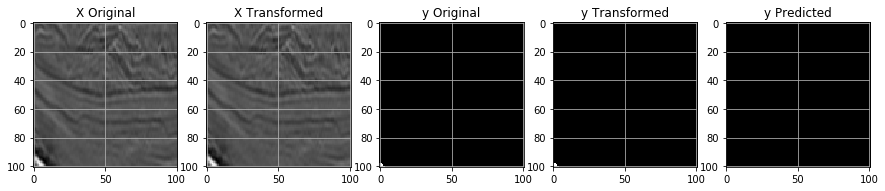

17/09/2018 23:40:34 - SaltNet - INFO - train Mean IOU: 0.5000, Mean Acc: 0.9994, Best Val IOU: 0.0000 at epoch 1
17/09/2018 23:40:39 - SaltNet - INFO - val Mean IOU: 0.0000, Mean Acc: 0.6139, Best Val IOU: 0.0000 at epoch 1
17/09/2018 23:40:39 - SaltNet - INFO - Epoch 2/100
17/09/2018 23:40:39 - SaltNet - INFO - --------------------
17/09/2018 23:40:53 - SaltNet - INFO - Losses: [0.0742, 0.78, 0.8542], Batch IOU: 0.0000, Batch Acc: 0.9989 at iter 4, epoch 2, Time: 0m 32s


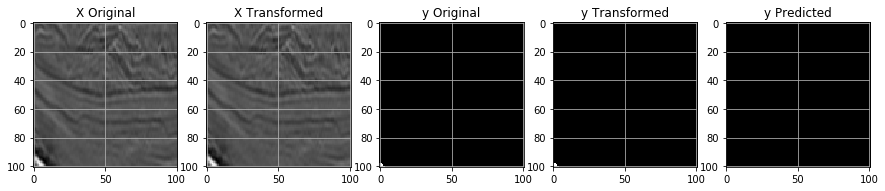

17/09/2018 23:40:53 - SaltNet - INFO - train Mean IOU: 0.5000, Mean Acc: 0.9994, Best Val IOU: 0.0000 at epoch 2
17/09/2018 23:40:59 - SaltNet - INFO - val Mean IOU: 0.0000, Mean Acc: 0.6139, Best Val IOU: 0.0000 at epoch 2
17/09/2018 23:40:59 - SaltNet - INFO - Epoch 3/100
17/09/2018 23:40:59 - SaltNet - INFO - --------------------


In [ ]:
train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.5), optimizer, scheduler, train_params, all_data)

In [111]:
epoch_losses

[[tensor(0.5482, grad_fn=<MulBackward>),
  tensor(0.6495, grad_fn=<MulBackward>)],
 [tensor(0.5549, grad_fn=<MulBackward>),
  tensor(0.3615, grad_fn=<MulBackward>)]]

In [112]:
losses = epoch_losses[0]

In [123]:
torch.stack(losses).sum()

tensor(1.1977, grad_fn=<SumBackward0>)

In [118]:
final_loss = losses[0] + losses[1]

In [ ]:
#!pip install boxx

## Train the full with full dataset

In [53]:
log.info('Use Unet with Resnet 34 as backbone run 3 with SGD.')

17/09/2018 04:48:31 - SaltNet - INFO - Use Unet with Resnet 34 as backbone run 3 with SGD.


In [ ]:
model_config = '''
p = Pipeline_Salt(min_mask_ratio=0.1)
#p.skew(probability=0.5, magnitude=0.2)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_random(probability=0.5, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': True}

val_data_params = {'batch_size': 32,
                   'shuffle': False,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

#saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
saltnet = UResNet(pretrained=True)
loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.SGD(saltnet.parameters(), lr=0.01)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=0.0001))

model_save_name = f'../salt_net/Unet_res34_focal_loss_se_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=300, print_every=50, save_model_every=20, save_log_every=2, log=log, loss1_weight=1.0, loss2_weight=0.1)

'''

In [41]:
log.info(model_config)

17/09/2018 00:45:35 - SaltNet - INFO - 
p = Pipeline_Salt(min_mask_ratio=0.1)
#p.skew(probability=0.5, magnitude=0.2)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_random(probability=0.5, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': True}

val_data_params = {'batch_size': 32,
                   'shuffle': False,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_

In [ ]:
p = Pipeline_Salt(min_mask_ratio=0.1)
#p.skew(probability=0.5, magnitude=0.2)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_random(probability=0.5, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': True}

val_data_params = {'batch_size': 32,
                   'shuffle': False,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

In [ ]:
saltnet

17/09/2018 04:49:51 - SaltNet - INFO - ../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp
17/09/2018 04:49:51 - SaltNet - INFO - Start Training...
17/09/2018 04:49:51 - SaltNet - INFO - Epoch 1/300
17/09/2018 04:49:51 - SaltNet - INFO - --------------------
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
17/09/2018 04:51:32 - SaltNet - INFO - Epoch total Loss: 0.2338, Epoch loss_1: 0.1844, Epoch loss_2: 0.0494, Batch IOU: 0.5938, Batch Acc: 0.8572 at iter 50, epoch 1, Time: 1m 40s


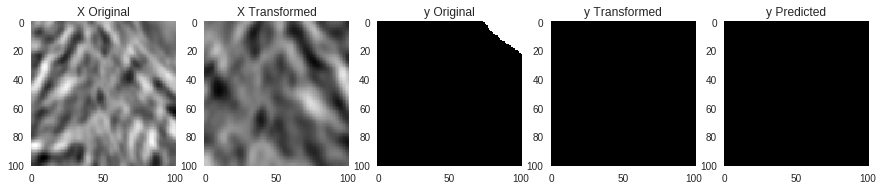

17/09/2018 04:53:13 - SaltNet - INFO - Epoch total Loss: 0.2258, Epoch loss_1: 0.1780, Epoch loss_2: 0.0477, Batch IOU: 0.6031, Batch Acc: 0.9569 at iter 100, epoch 1, Time: 3m 22s


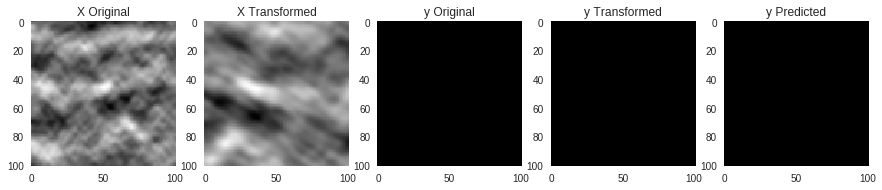

17/09/2018 04:53:15 - SaltNet - INFO - train Mean IOU: 0.7129, Mean Acc: 0.9359, Best Val IOU: 0.0000 at epoch 1
17/09/2018 04:53:29 - SaltNet - INFO - val Mean IOU: 0.7080, Mean Acc: 0.9433, Best Val IOU: 0.0000 at epoch 1
17/09/2018 04:53:29 - SaltNet - INFO - ['../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-1-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-2-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-3-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-4-Of-4']
17/09/2018 04:53:29 - SaltNet - INFO - Best Val Mean IOU so far: 0.7080000000000001


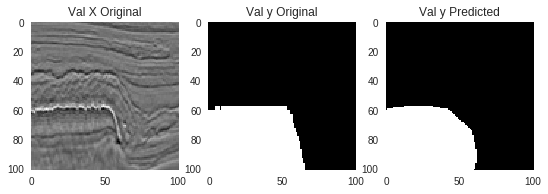

17/09/2018 04:53:29 - SaltNet - INFO - Epoch 2/300
17/09/2018 04:53:29 - SaltNet - INFO - --------------------
17/09/2018 04:53:29 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master a9c19a5] Pushing logs to git
 1 file changed, 14 insertions(+)
 create mode 100644 logs/SaltNet_2018_09_17_14h.log
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 765 bytes | 765.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/allen-q/salt_net.git
   abcd709..a9c19a5  master -> master


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
17/09/2018 04:55:29 - SaltNet - INFO - Epoch total Loss: 0.2226, Epoch loss_1: 0.1757, Epoch loss_2: 0.0469, Batch IOU: 0.6687, Batch Acc: 0.8700 at iter 150, epoch 2, Time: 5m 38s


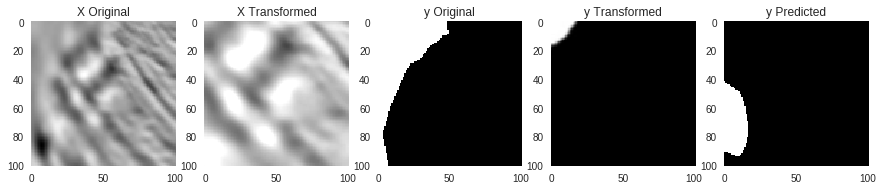

17/09/2018 04:57:11 - SaltNet - INFO - Epoch total Loss: 0.2222, Epoch loss_1: 0.1735, Epoch loss_2: 0.0488, Batch IOU: 0.6094, Batch Acc: 0.9491 at iter 200, epoch 2, Time: 7m 19s


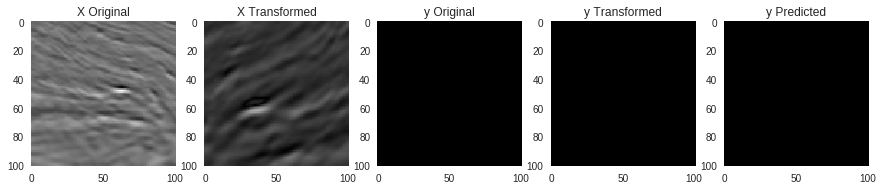

17/09/2018 04:57:12 - SaltNet - INFO - train Mean IOU: 0.7076, Mean Acc: 0.9371, Best Val IOU: 0.7080 at epoch 2
17/09/2018 04:57:26 - SaltNet - INFO - val Mean IOU: 0.7087, Mean Acc: 0.9393, Best Val IOU: 0.7080 at epoch 2
17/09/2018 04:57:27 - SaltNet - INFO - ['../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-1-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-2-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-3-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-4-Of-4']
17/09/2018 04:57:27 - SaltNet - INFO - Best Val Mean IOU so far: 0.70875


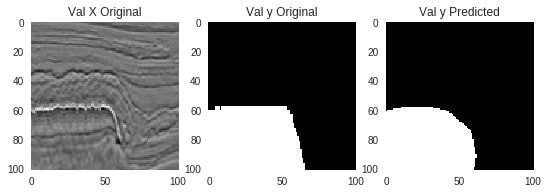

17/09/2018 04:57:27 - SaltNet - INFO - Epoch 3/300
17/09/2018 04:57:27 - SaltNet - INFO - --------------------
17/09/2018 04:59:08 - SaltNet - INFO - Epoch total Loss: 0.2248, Epoch loss_1: 0.1787, Epoch loss_2: 0.0461, Batch IOU: 0.6781, Batch Acc: 0.9650 at iter 250, epoch 3, Time: 9m 16s


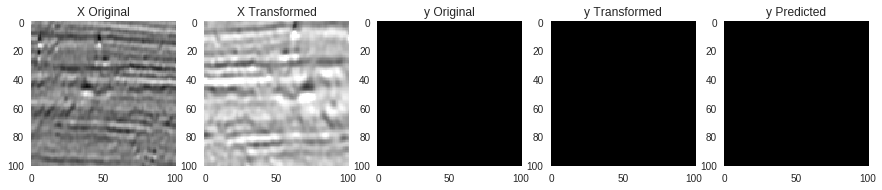

17/09/2018 05:00:49 - SaltNet - INFO - Epoch total Loss: 0.2229, Epoch loss_1: 0.1751, Epoch loss_2: 0.0478, Batch IOU: 0.7750, Batch Acc: 0.9643 at iter 300, epoch 3, Time: 10m 58s


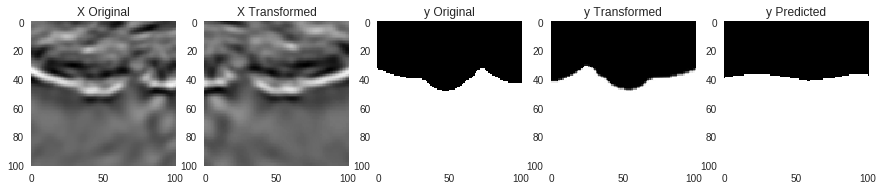

17/09/2018 05:00:50 - SaltNet - INFO - train Mean IOU: 0.7111, Mean Acc: 0.9386, Best Val IOU: 0.7087 at epoch 3
17/09/2018 05:01:04 - SaltNet - INFO - val Mean IOU: 0.7142, Mean Acc: 0.9422, Best Val IOU: 0.7087 at epoch 3
17/09/2018 05:01:05 - SaltNet - INFO - ['../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-1-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-2-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-3-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-4-Of-4']
17/09/2018 05:01:05 - SaltNet - INFO - Best Val Mean IOU so far: 0.7142499999999999


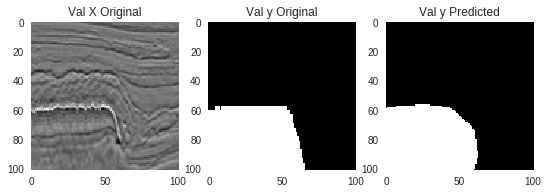

17/09/2018 05:01:05 - SaltNet - INFO - Epoch 4/300
17/09/2018 05:01:05 - SaltNet - INFO - --------------------
17/09/2018 05:01:05 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 72d7b86] Pushing logs to git
 1 file changed, 17 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1022 bytes | 1022.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/allen-q/salt_net.git
   a9c19a5..72d7b86  master -> master


17/09/2018 05:03:03 - SaltNet - INFO - Epoch total Loss: 0.2308, Epoch loss_1: 0.1815, Epoch loss_2: 0.0493, Batch IOU: 0.5687, Batch Acc: 0.9105 at iter 350, epoch 4, Time: 13m 12s


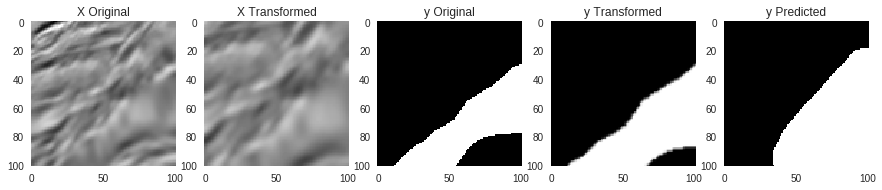

17/09/2018 05:04:44 - SaltNet - INFO - Epoch total Loss: 0.2304, Epoch loss_1: 0.1824, Epoch loss_2: 0.0480, Batch IOU: 0.7281, Batch Acc: 0.9391 at iter 400, epoch 4, Time: 14m 53s


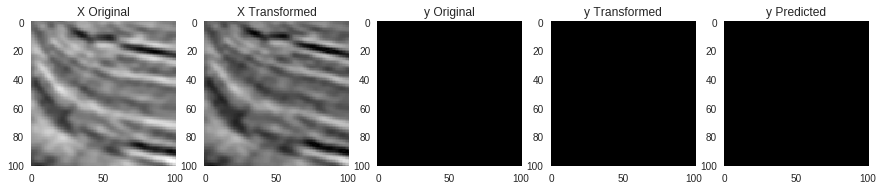

17/09/2018 05:04:46 - SaltNet - INFO - train Mean IOU: 0.7164, Mean Acc: 0.9358, Best Val IOU: 0.7142 at epoch 4
17/09/2018 05:04:59 - SaltNet - INFO - val Mean IOU: 0.7026, Mean Acc: 0.9411, Best Val IOU: 0.7142 at epoch 4
17/09/2018 05:04:59 - SaltNet - INFO - Epoch 5/300
17/09/2018 05:04:59 - SaltNet - INFO - --------------------
17/09/2018 05:06:40 - SaltNet - INFO - Epoch total Loss: 0.2353, Epoch loss_1: 0.1855, Epoch loss_2: 0.0499, Batch IOU: 0.6969, Batch Acc: 0.8977 at iter 450, epoch 5, Time: 16m 49s


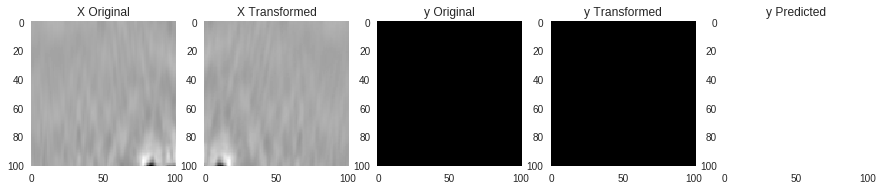

17/09/2018 05:08:21 - SaltNet - INFO - Epoch total Loss: 0.2233, Epoch loss_1: 0.1760, Epoch loss_2: 0.0473, Batch IOU: 0.7562, Batch Acc: 0.9458 at iter 500, epoch 5, Time: 18m 30s


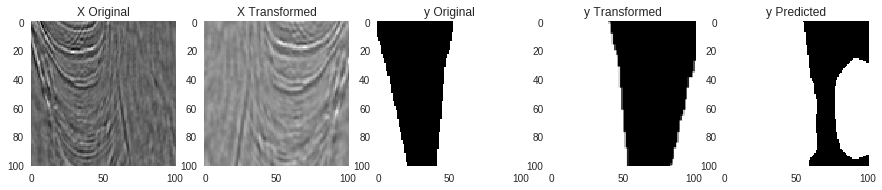

17/09/2018 05:08:22 - SaltNet - INFO - train Mean IOU: 0.7083, Mean Acc: 0.9358, Best Val IOU: 0.7142 at epoch 5
17/09/2018 05:08:36 - SaltNet - INFO - val Mean IOU: 0.7120, Mean Acc: 0.9434, Best Val IOU: 0.7142 at epoch 5
17/09/2018 05:08:36 - SaltNet - INFO - Epoch 6/300
17/09/2018 05:08:36 - SaltNet - INFO - --------------------
17/09/2018 05:08:36 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 01e0bca] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 709 bytes | 709.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   72d7b86..01e0bca  master -> master


17/09/2018 05:10:34 - SaltNet - INFO - Epoch total Loss: 0.2401, Epoch loss_1: 0.1892, Epoch loss_2: 0.0509, Batch IOU: 0.6219, Batch Acc: 0.9145 at iter 550, epoch 6, Time: 20m 43s


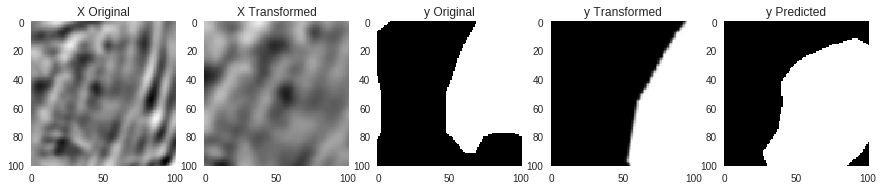

17/09/2018 05:12:16 - SaltNet - INFO - Epoch total Loss: 0.2238, Epoch loss_1: 0.1758, Epoch loss_2: 0.0480, Batch IOU: 0.6281, Batch Acc: 0.9177 at iter 600, epoch 6, Time: 22m 24s


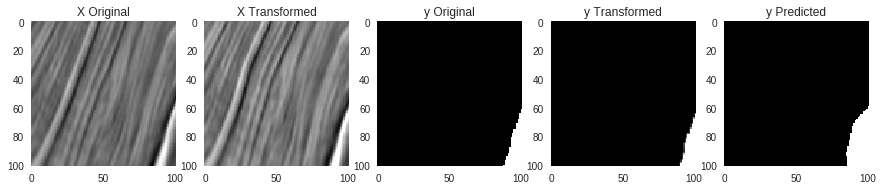

17/09/2018 05:12:17 - SaltNet - INFO - train Mean IOU: 0.7100, Mean Acc: 0.9357, Best Val IOU: 0.7142 at epoch 6
17/09/2018 05:12:31 - SaltNet - INFO - val Mean IOU: 0.7139, Mean Acc: 0.9433, Best Val IOU: 0.7142 at epoch 6
17/09/2018 05:12:31 - SaltNet - INFO - Epoch 7/300
17/09/2018 05:12:31 - SaltNet - INFO - --------------------
17/09/2018 05:14:12 - SaltNet - INFO - Epoch total Loss: 0.2316, Epoch loss_1: 0.1818, Epoch loss_2: 0.0498, Batch IOU: 0.5844, Batch Acc: 0.9171 at iter 650, epoch 7, Time: 24m 20s


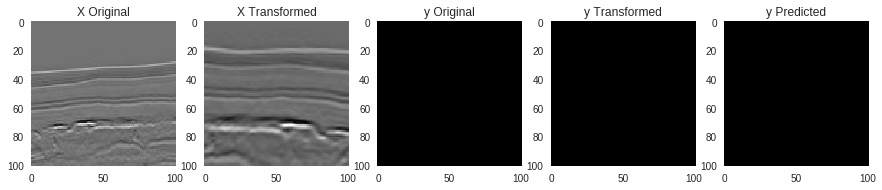

17/09/2018 05:15:53 - SaltNet - INFO - Epoch total Loss: 0.2227, Epoch loss_1: 0.1748, Epoch loss_2: 0.0479, Batch IOU: 0.6250, Batch Acc: 0.9381 at iter 700, epoch 7, Time: 26m 1s


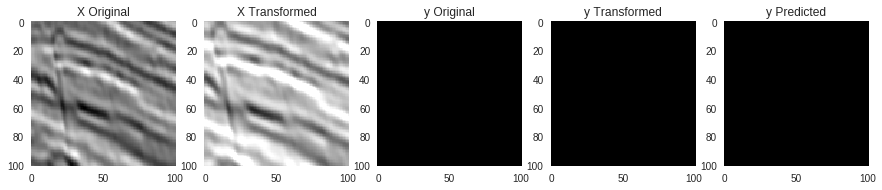

17/09/2018 05:15:54 - SaltNet - INFO - train Mean IOU: 0.7055, Mean Acc: 0.9353, Best Val IOU: 0.7142 at epoch 7
17/09/2018 05:16:08 - SaltNet - INFO - val Mean IOU: 0.7103, Mean Acc: 0.9432, Best Val IOU: 0.7142 at epoch 7
17/09/2018 05:16:08 - SaltNet - INFO - Epoch 8/300
17/09/2018 05:16:08 - SaltNet - INFO - --------------------
17/09/2018 05:16:08 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master c134108] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 712 bytes | 712.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   01e0bca..c134108  master -> master


17/09/2018 05:18:07 - SaltNet - INFO - Epoch total Loss: 0.2230, Epoch loss_1: 0.1742, Epoch loss_2: 0.0488, Batch IOU: 0.7500, Batch Acc: 0.9620 at iter 750, epoch 8, Time: 28m 16s


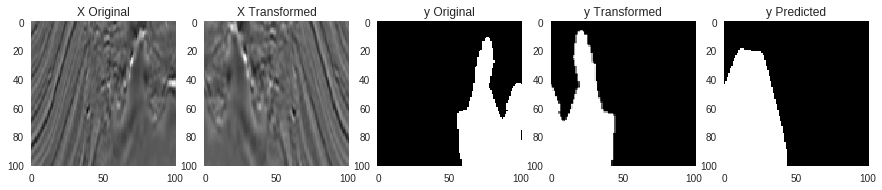

17/09/2018 05:19:49 - SaltNet - INFO - Epoch total Loss: 0.2163, Epoch loss_1: 0.1688, Epoch loss_2: 0.0475, Batch IOU: 0.7063, Batch Acc: 0.9462 at iter 800, epoch 8, Time: 29m 57s


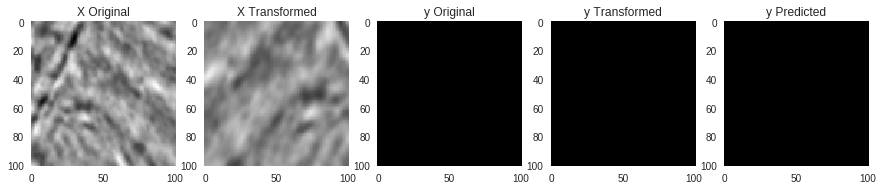

17/09/2018 05:19:50 - SaltNet - INFO - train Mean IOU: 0.7144, Mean Acc: 0.9369, Best Val IOU: 0.7142 at epoch 8
17/09/2018 05:20:04 - SaltNet - INFO - val Mean IOU: 0.7000, Mean Acc: 0.9358, Best Val IOU: 0.7142 at epoch 8
17/09/2018 05:20:04 - SaltNet - INFO - Epoch 9/300
17/09/2018 05:20:04 - SaltNet - INFO - --------------------
17/09/2018 05:21:45 - SaltNet - INFO - Epoch total Loss: 0.2099, Epoch loss_1: 0.1603, Epoch loss_2: 0.0497, Batch IOU: 0.8469, Batch Acc: 0.9806 at iter 850, epoch 9, Time: 31m 53s


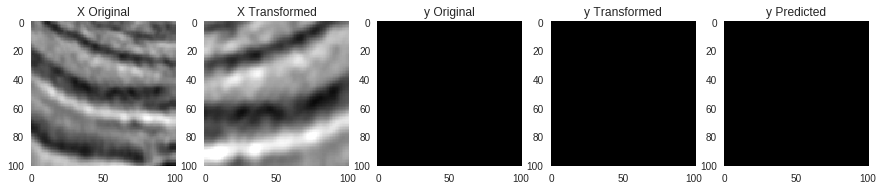

17/09/2018 05:23:26 - SaltNet - INFO - Epoch total Loss: 0.2086, Epoch loss_1: 0.1614, Epoch loss_2: 0.0473, Batch IOU: 0.7219, Batch Acc: 0.9544 at iter 900, epoch 9, Time: 33m 34s


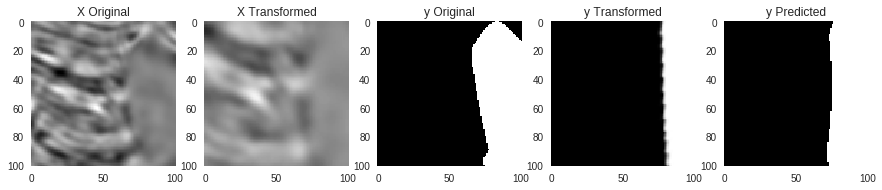

17/09/2018 05:23:27 - SaltNet - INFO - train Mean IOU: 0.7140, Mean Acc: 0.9397, Best Val IOU: 0.7142 at epoch 9
17/09/2018 05:23:41 - SaltNet - INFO - val Mean IOU: 0.7000, Mean Acc: 0.9407, Best Val IOU: 0.7142 at epoch 9
17/09/2018 05:23:41 - SaltNet - INFO - Epoch 10/300
17/09/2018 05:23:41 - SaltNet - INFO - --------------------
17/09/2018 05:23:41 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 0fa766b] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 705 bytes | 705.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   c134108..0fa766b  master -> master


17/09/2018 05:25:41 - SaltNet - INFO - Epoch total Loss: 0.2077, Epoch loss_1: 0.1618, Epoch loss_2: 0.0459, Batch IOU: 0.6844, Batch Acc: 0.9078 at iter 950, epoch 10, Time: 35m 49s


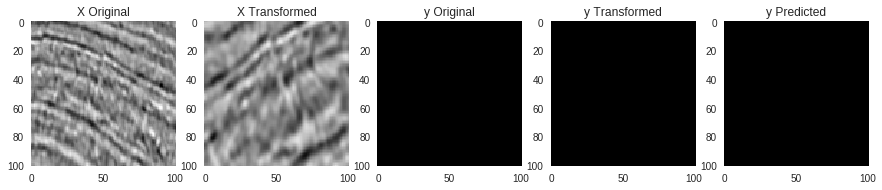

17/09/2018 05:27:22 - SaltNet - INFO - Epoch total Loss: 0.2180, Epoch loss_1: 0.1704, Epoch loss_2: 0.0476, Batch IOU: 0.7188, Batch Acc: 0.9017 at iter 1000, epoch 10, Time: 37m 30s


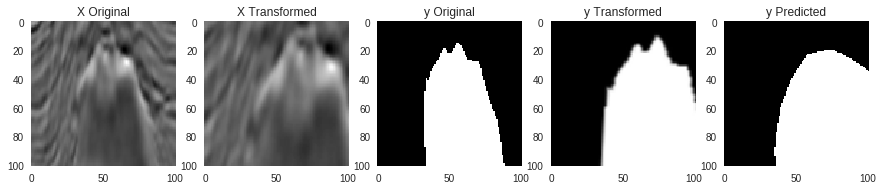

17/09/2018 05:27:23 - SaltNet - INFO - train Mean IOU: 0.7148, Mean Acc: 0.9381, Best Val IOU: 0.7142 at epoch 10
17/09/2018 05:27:37 - SaltNet - INFO - val Mean IOU: 0.7060, Mean Acc: 0.9386, Best Val IOU: 0.7142 at epoch 10
17/09/2018 05:27:37 - SaltNet - INFO - Epoch 11/300
17/09/2018 05:27:37 - SaltNet - INFO - --------------------
17/09/2018 05:29:17 - SaltNet - INFO - Epoch total Loss: 0.2077, Epoch loss_1: 0.1640, Epoch loss_2: 0.0438, Batch IOU: 0.7594, Batch Acc: 0.9470 at iter 1050, epoch 11, Time: 39m 26s


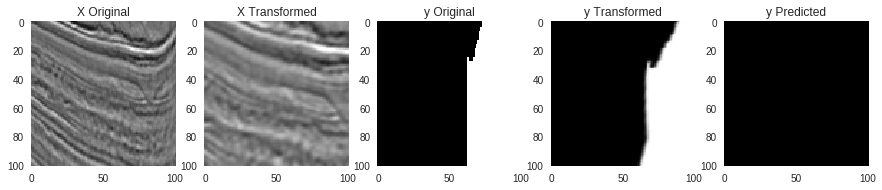

17/09/2018 05:30:58 - SaltNet - INFO - Epoch total Loss: 0.2104, Epoch loss_1: 0.1654, Epoch loss_2: 0.0450, Batch IOU: 0.6469, Batch Acc: 0.9066 at iter 1100, epoch 11, Time: 41m 7s


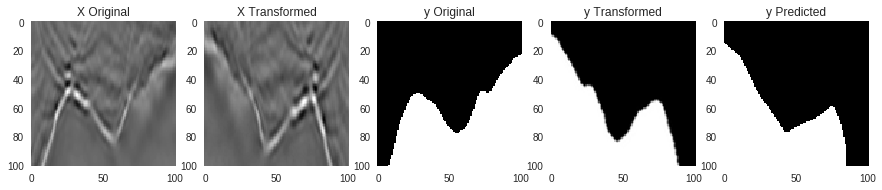

17/09/2018 05:30:59 - SaltNet - INFO - train Mean IOU: 0.7200, Mean Acc: 0.9391, Best Val IOU: 0.7142 at epoch 11
17/09/2018 05:31:13 - SaltNet - INFO - val Mean IOU: 0.7150, Mean Acc: 0.9421, Best Val IOU: 0.7142 at epoch 11
17/09/2018 05:31:14 - SaltNet - INFO - ['../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-1-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-2-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-3-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-4-Of-4']
17/09/2018 05:31:14 - SaltNet - INFO - Best Val Mean IOU so far: 0.715


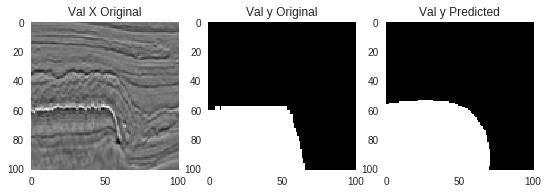

17/09/2018 05:31:14 - SaltNet - INFO - Epoch 12/300
17/09/2018 05:31:14 - SaltNet - INFO - --------------------
17/09/2018 05:31:14 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 8b1026e] Pushing logs to git
 1 file changed, 15 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 723 bytes | 723.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   0fa766b..8b1026e  master -> master
Epoch    11: reducing learning rate of group 0 to 5.0000e-04.


17/09/2018 05:33:15 - SaltNet - INFO - Epoch total Loss: 0.2043, Epoch loss_1: 0.1601, Epoch loss_2: 0.0442, Batch IOU: 0.6906, Batch Acc: 0.9716 at iter 1150, epoch 12, Time: 43m 23s


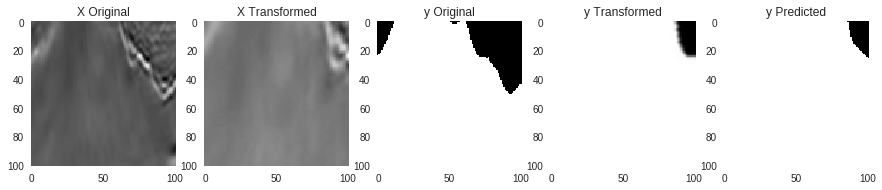

17/09/2018 05:34:56 - SaltNet - INFO - Epoch total Loss: 0.2101, Epoch loss_1: 0.1650, Epoch loss_2: 0.0451, Batch IOU: 0.6906, Batch Acc: 0.9505 at iter 1200, epoch 12, Time: 45m 4s


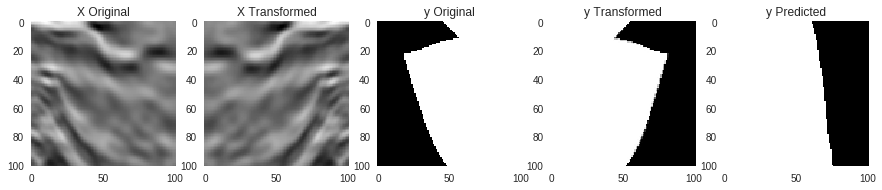

17/09/2018 05:34:57 - SaltNet - INFO - train Mean IOU: 0.7228, Mean Acc: 0.9399, Best Val IOU: 0.7150 at epoch 12
17/09/2018 05:35:11 - SaltNet - INFO - val Mean IOU: 0.7147, Mean Acc: 0.9422, Best Val IOU: 0.7150 at epoch 12
17/09/2018 05:35:11 - SaltNet - INFO - Epoch 13/300
17/09/2018 05:35:11 - SaltNet - INFO - --------------------
17/09/2018 05:36:52 - SaltNet - INFO - Epoch total Loss: 0.2158, Epoch loss_1: 0.1687, Epoch loss_2: 0.0472, Batch IOU: 0.7063, Batch Acc: 0.8954 at iter 1250, epoch 13, Time: 47m 0s


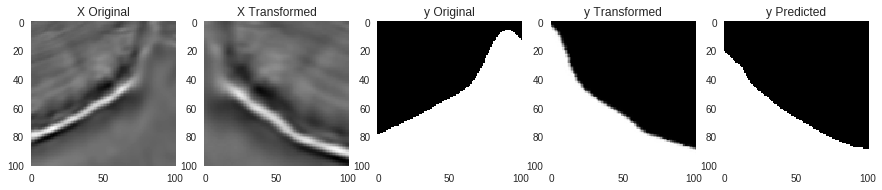

17/09/2018 05:38:33 - SaltNet - INFO - Epoch total Loss: 0.2032, Epoch loss_1: 0.1570, Epoch loss_2: 0.0462, Batch IOU: 0.6844, Batch Acc: 0.9619 at iter 1300, epoch 13, Time: 48m 41s


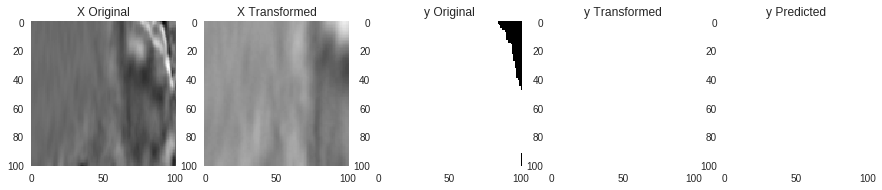

17/09/2018 05:38:34 - SaltNet - INFO - train Mean IOU: 0.7168, Mean Acc: 0.9406, Best Val IOU: 0.7150 at epoch 13
17/09/2018 05:38:48 - SaltNet - INFO - val Mean IOU: 0.7140, Mean Acc: 0.9408, Best Val IOU: 0.7150 at epoch 13
17/09/2018 05:38:48 - SaltNet - INFO - Epoch 14/300
17/09/2018 05:38:48 - SaltNet - INFO - --------------------
17/09/2018 05:38:48 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master f8e2478] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 708 bytes | 708.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   8b1026e..f8e2478  master -> master


17/09/2018 05:40:47 - SaltNet - INFO - Epoch total Loss: 0.2131, Epoch loss_1: 0.1696, Epoch loss_2: 0.0436, Batch IOU: 0.6406, Batch Acc: 0.9323 at iter 1350, epoch 14, Time: 50m 56s


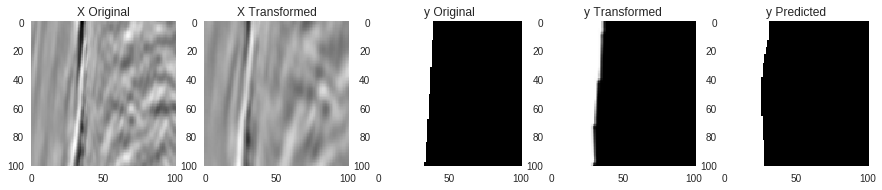

17/09/2018 05:42:28 - SaltNet - INFO - Epoch total Loss: 0.2040, Epoch loss_1: 0.1600, Epoch loss_2: 0.0440, Batch IOU: 0.7125, Batch Acc: 0.9606 at iter 1400, epoch 14, Time: 52m 37s


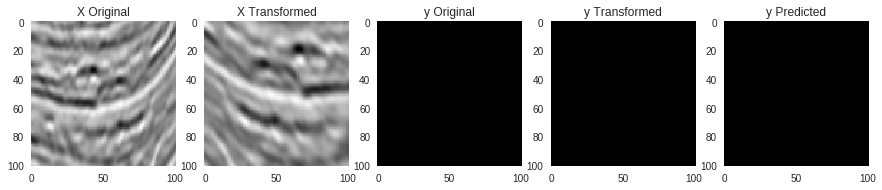

17/09/2018 05:42:30 - SaltNet - INFO - train Mean IOU: 0.7250, Mean Acc: 0.9415, Best Val IOU: 0.7150 at epoch 14
17/09/2018 05:42:43 - SaltNet - INFO - val Mean IOU: 0.7175, Mean Acc: 0.9429, Best Val IOU: 0.7150 at epoch 14
17/09/2018 05:42:44 - SaltNet - INFO - ['../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-1-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-2-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-3-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-4-Of-4']
17/09/2018 05:42:44 - SaltNet - INFO - Best Val Mean IOU so far: 0.7175


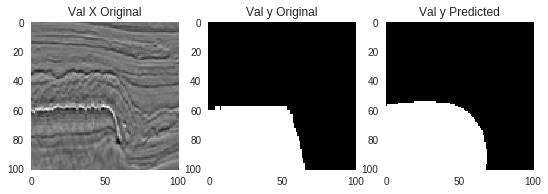

17/09/2018 05:42:44 - SaltNet - INFO - Epoch 15/300
17/09/2018 05:42:44 - SaltNet - INFO - --------------------
17/09/2018 05:44:25 - SaltNet - INFO - Epoch total Loss: 0.2036, Epoch loss_1: 0.1572, Epoch loss_2: 0.0465, Batch IOU: 0.6750, Batch Acc: 0.9530 at iter 1450, epoch 15, Time: 54m 34s


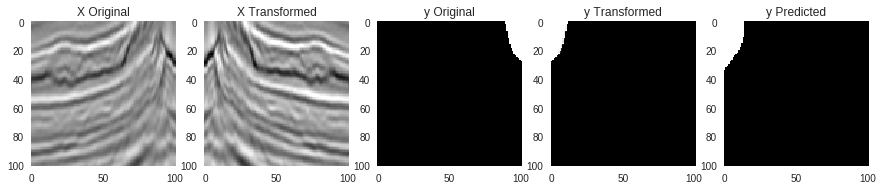

17/09/2018 05:46:06 - SaltNet - INFO - Epoch total Loss: 0.2048, Epoch loss_1: 0.1585, Epoch loss_2: 0.0463, Batch IOU: 0.6656, Batch Acc: 0.9324 at iter 1500, epoch 15, Time: 56m 15s


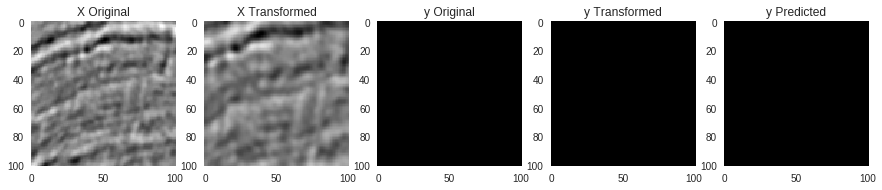

17/09/2018 05:46:07 - SaltNet - INFO - train Mean IOU: 0.7172, Mean Acc: 0.9413, Best Val IOU: 0.7175 at epoch 15
17/09/2018 05:46:21 - SaltNet - INFO - val Mean IOU: 0.7129, Mean Acc: 0.9425, Best Val IOU: 0.7175 at epoch 15
17/09/2018 05:46:21 - SaltNet - INFO - Epoch 16/300
17/09/2018 05:46:21 - SaltNet - INFO - --------------------
17/09/2018 05:46:21 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 0de8860] Pushing logs to git
 1 file changed, 15 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 724 bytes | 724.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   f8e2478..0de8860  master -> master


17/09/2018 05:48:22 - SaltNet - INFO - Epoch total Loss: 0.2046, Epoch loss_1: 0.1579, Epoch loss_2: 0.0467, Batch IOU: 0.6812, Batch Acc: 0.9420 at iter 1550, epoch 16, Time: 58m 30s


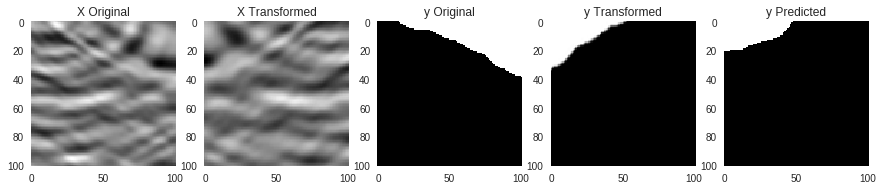

17/09/2018 05:50:03 - SaltNet - INFO - Epoch total Loss: 0.2075, Epoch loss_1: 0.1606, Epoch loss_2: 0.0470, Batch IOU: 0.8031, Batch Acc: 0.9596 at iter 1600, epoch 16, Time: 60m 11s


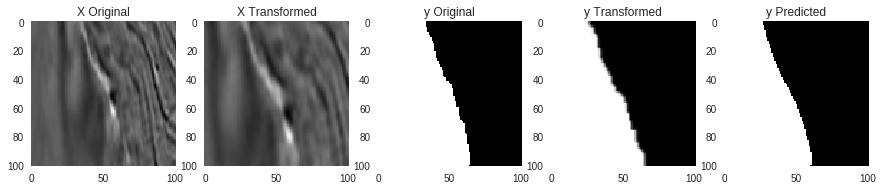

17/09/2018 05:50:04 - SaltNet - INFO - train Mean IOU: 0.7191, Mean Acc: 0.9406, Best Val IOU: 0.7175 at epoch 16
17/09/2018 05:50:18 - SaltNet - INFO - val Mean IOU: 0.7122, Mean Acc: 0.9417, Best Val IOU: 0.7175 at epoch 16
17/09/2018 05:50:18 - SaltNet - INFO - Epoch 17/300
17/09/2018 05:50:18 - SaltNet - INFO - --------------------
17/09/2018 05:51:58 - SaltNet - INFO - Epoch total Loss: 0.1983, Epoch loss_1: 0.1542, Epoch loss_2: 0.0441, Batch IOU: 0.6969, Batch Acc: 0.9014 at iter 1650, epoch 17, Time: 62m 7s


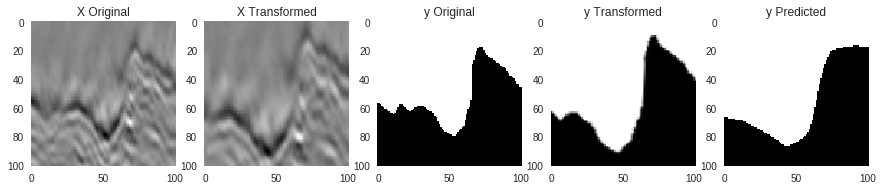

17/09/2018 05:53:39 - SaltNet - INFO - Epoch total Loss: 0.2014, Epoch loss_1: 0.1571, Epoch loss_2: 0.0443, Batch IOU: 0.7500, Batch Acc: 0.9562 at iter 1700, epoch 17, Time: 63m 48s


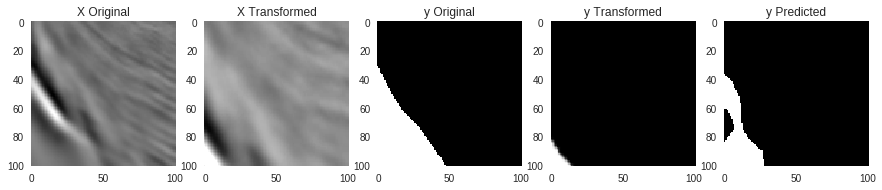

17/09/2018 05:53:40 - SaltNet - INFO - train Mean IOU: 0.7250, Mean Acc: 0.9426, Best Val IOU: 0.7175 at epoch 17
17/09/2018 05:53:54 - SaltNet - INFO - val Mean IOU: 0.7120, Mean Acc: 0.9423, Best Val IOU: 0.7175 at epoch 17
17/09/2018 05:53:54 - SaltNet - INFO - Epoch 18/300
17/09/2018 05:53:54 - SaltNet - INFO - --------------------
17/09/2018 05:53:54 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 05f71a7] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 704 bytes | 704.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   0de8860..05f71a7  master -> master


17/09/2018 05:55:56 - SaltNet - INFO - Epoch total Loss: 0.1880, Epoch loss_1: 0.1443, Epoch loss_2: 0.0437, Batch IOU: 0.7312, Batch Acc: 0.9300 at iter 1750, epoch 18, Time: 66m 5s


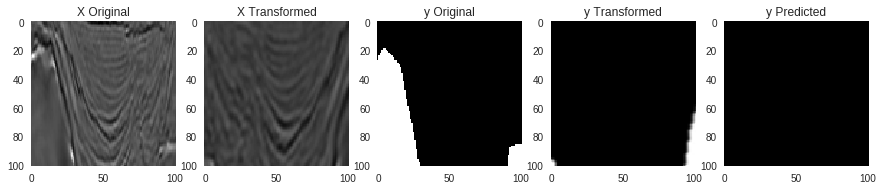

17/09/2018 05:57:37 - SaltNet - INFO - Epoch total Loss: 0.2036, Epoch loss_1: 0.1585, Epoch loss_2: 0.0452, Batch IOU: 0.7000, Batch Acc: 0.9630 at iter 1800, epoch 18, Time: 67m 45s


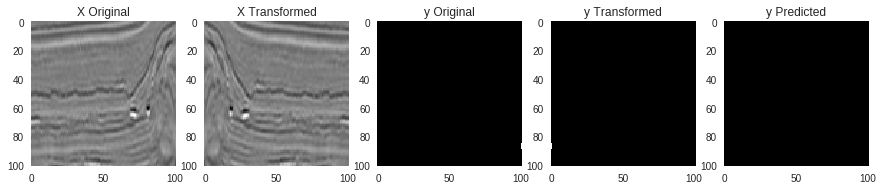

17/09/2018 05:57:38 - SaltNet - INFO - train Mean IOU: 0.7216, Mean Acc: 0.9419, Best Val IOU: 0.7175 at epoch 18
17/09/2018 05:57:52 - SaltNet - INFO - val Mean IOU: 0.7090, Mean Acc: 0.9400, Best Val IOU: 0.7175 at epoch 18
17/09/2018 05:57:52 - SaltNet - INFO - Epoch 19/300
17/09/2018 05:57:52 - SaltNet - INFO - --------------------
17/09/2018 05:59:33 - SaltNet - INFO - Epoch total Loss: 0.1903, Epoch loss_1: 0.1441, Epoch loss_2: 0.0461, Batch IOU: 0.6969, Batch Acc: 0.9680 at iter 1850, epoch 19, Time: 69m 41s


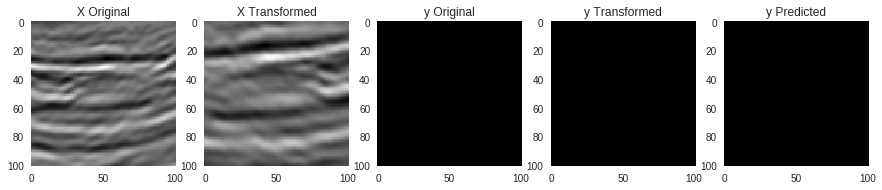

17/09/2018 06:01:14 - SaltNet - INFO - Epoch total Loss: 0.2021, Epoch loss_1: 0.1557, Epoch loss_2: 0.0463, Batch IOU: 0.7688, Batch Acc: 0.9138 at iter 1900, epoch 19, Time: 71m 22s


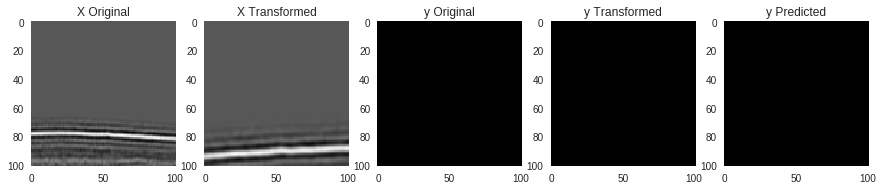

17/09/2018 06:01:15 - SaltNet - INFO - train Mean IOU: 0.7166, Mean Acc: 0.9415, Best Val IOU: 0.7175 at epoch 19
17/09/2018 06:01:29 - SaltNet - INFO - val Mean IOU: 0.7128, Mean Acc: 0.9430, Best Val IOU: 0.7175 at epoch 19
17/09/2018 06:01:29 - SaltNet - INFO - Epoch 20/300
17/09/2018 06:01:29 - SaltNet - INFO - --------------------
17/09/2018 06:01:29 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 245ed4f] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 701 bytes | 701.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   05f71a7..245ed4f  master -> master


17/09/2018 06:03:27 - SaltNet - INFO - Epoch total Loss: 0.2098, Epoch loss_1: 0.1634, Epoch loss_2: 0.0464, Batch IOU: 0.7063, Batch Acc: 0.9499 at iter 1950, epoch 20, Time: 73m 36s


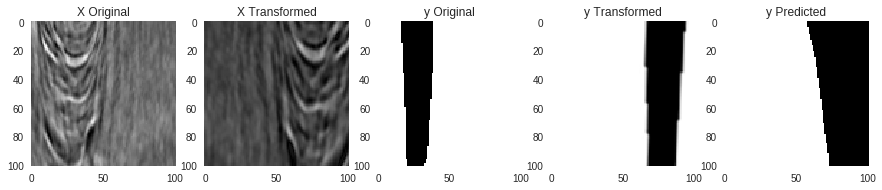

17/09/2018 06:05:09 - SaltNet - INFO - Epoch total Loss: 0.2038, Epoch loss_1: 0.1582, Epoch loss_2: 0.0456, Batch IOU: 0.8000, Batch Acc: 0.9657 at iter 2000, epoch 20, Time: 75m 17s


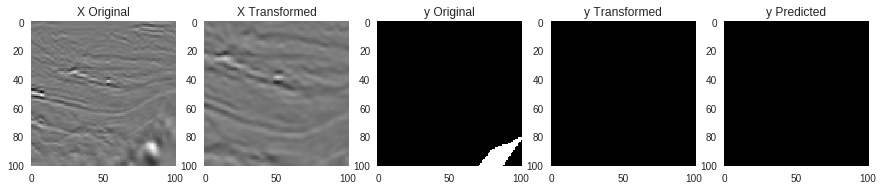

17/09/2018 06:05:10 - SaltNet - INFO - train Mean IOU: 0.7195, Mean Acc: 0.9412, Best Val IOU: 0.7175 at epoch 20
17/09/2018 06:05:24 - SaltNet - INFO - val Mean IOU: 0.7156, Mean Acc: 0.9433, Best Val IOU: 0.7175 at epoch 20
17/09/2018 06:05:24 - SaltNet - INFO - Skip pushing model to git as there's no improvement
17/09/2018 06:05:24 - SaltNet - INFO - Epoch 21/300
17/09/2018 06:05:24 - SaltNet - INFO - --------------------
17/09/2018 06:07:04 - SaltNet - INFO - Epoch total Loss: 0.1852, Epoch loss_1: 0.1425, Epoch loss_2: 0.0428, Batch IOU: 0.7094, Batch Acc: 0.9012 at iter 2050, epoch 21, Time: 77m 13s


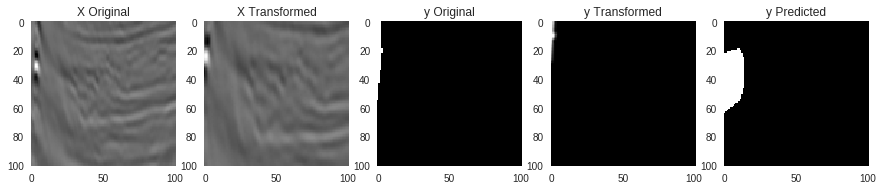

17/09/2018 06:08:45 - SaltNet - INFO - Epoch total Loss: 0.2036, Epoch loss_1: 0.1582, Epoch loss_2: 0.0453, Batch IOU: 0.7188, Batch Acc: 0.9282 at iter 2100, epoch 21, Time: 78m 54s


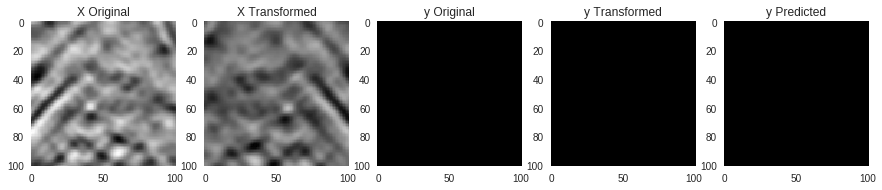

17/09/2018 06:08:46 - SaltNet - INFO - train Mean IOU: 0.7191, Mean Acc: 0.9415, Best Val IOU: 0.7175 at epoch 21
17/09/2018 06:09:00 - SaltNet - INFO - val Mean IOU: 0.7150, Mean Acc: 0.9432, Best Val IOU: 0.7175 at epoch 21
17/09/2018 06:09:00 - SaltNet - INFO - Epoch 22/300
17/09/2018 06:09:00 - SaltNet - INFO - --------------------
17/09/2018 06:09:00 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 049eee4] Pushing logs to git
 1 file changed, 14 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 768 bytes | 768.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   245ed4f..049eee4  master -> master


17/09/2018 06:11:02 - SaltNet - INFO - Epoch total Loss: 0.2056, Epoch loss_1: 0.1615, Epoch loss_2: 0.0440, Batch IOU: 0.7750, Batch Acc: 0.9633 at iter 2150, epoch 22, Time: 81m 11s


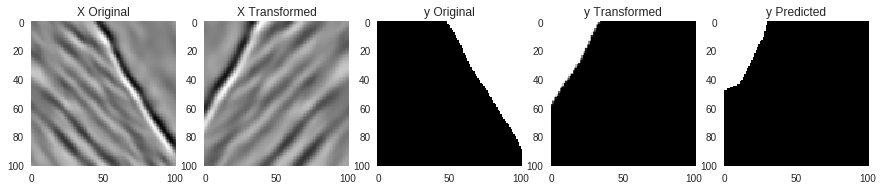

17/09/2018 06:12:43 - SaltNet - INFO - Epoch total Loss: 0.1989, Epoch loss_1: 0.1547, Epoch loss_2: 0.0443, Batch IOU: 0.6625, Batch Acc: 0.9052 at iter 2200, epoch 22, Time: 82m 52s


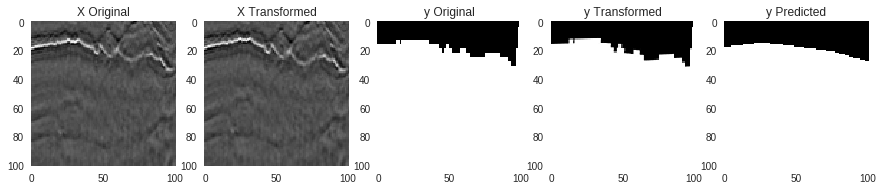

17/09/2018 06:12:44 - SaltNet - INFO - train Mean IOU: 0.7238, Mean Acc: 0.9420, Best Val IOU: 0.7175 at epoch 22
17/09/2018 06:12:58 - SaltNet - INFO - val Mean IOU: 0.7156, Mean Acc: 0.9449, Best Val IOU: 0.7175 at epoch 22
17/09/2018 06:12:58 - SaltNet - INFO - Epoch 23/300
17/09/2018 06:12:58 - SaltNet - INFO - --------------------


Epoch    22: reducing learning rate of group 0 to 5.0000e-05.


17/09/2018 06:14:39 - SaltNet - INFO - Epoch total Loss: 0.1982, Epoch loss_1: 0.1538, Epoch loss_2: 0.0445, Batch IOU: 0.7094, Batch Acc: 0.9646 at iter 2250, epoch 23, Time: 84m 47s


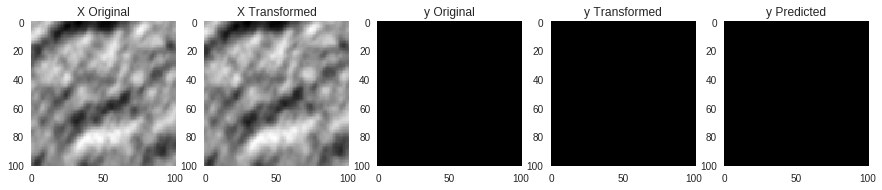

17/09/2018 06:16:20 - SaltNet - INFO - Epoch total Loss: 0.1941, Epoch loss_1: 0.1507, Epoch loss_2: 0.0434, Batch IOU: 0.7063, Batch Acc: 0.9149 at iter 2300, epoch 23, Time: 86m 28s


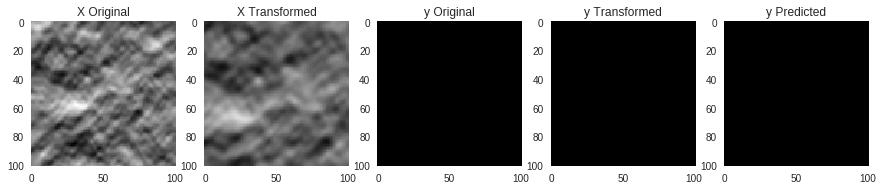

17/09/2018 06:16:21 - SaltNet - INFO - train Mean IOU: 0.7252, Mean Acc: 0.9421, Best Val IOU: 0.7175 at epoch 23
17/09/2018 06:16:35 - SaltNet - INFO - val Mean IOU: 0.7180, Mean Acc: 0.9430, Best Val IOU: 0.7175 at epoch 23
17/09/2018 06:16:35 - SaltNet - INFO - ['../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-1-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-2-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-3-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-4-Of-4']
17/09/2018 06:16:35 - SaltNet - INFO - Best Val Mean IOU so far: 0.718


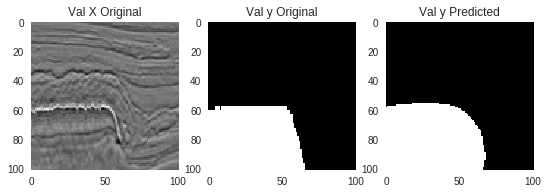

17/09/2018 06:16:36 - SaltNet - INFO - Epoch 24/300
17/09/2018 06:16:36 - SaltNet - INFO - --------------------
17/09/2018 06:16:36 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master fe81099] Pushing logs to git
 1 file changed, 15 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 703 bytes | 703.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   049eee4..fe81099  master -> master


17/09/2018 06:18:37 - SaltNet - INFO - Epoch total Loss: 0.1914, Epoch loss_1: 0.1488, Epoch loss_2: 0.0426, Batch IOU: 0.7437, Batch Acc: 0.9269 at iter 2350, epoch 24, Time: 88m 46s


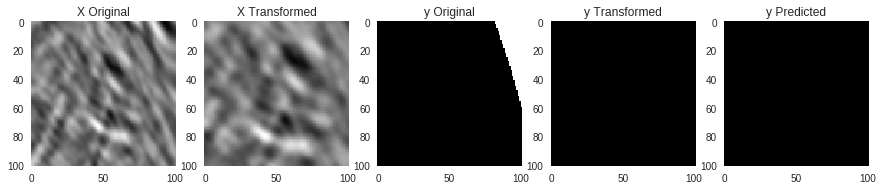

17/09/2018 06:20:18 - SaltNet - INFO - Epoch total Loss: 0.1982, Epoch loss_1: 0.1535, Epoch loss_2: 0.0447, Batch IOU: 0.7281, Batch Acc: 0.8999 at iter 2400, epoch 24, Time: 90m 27s


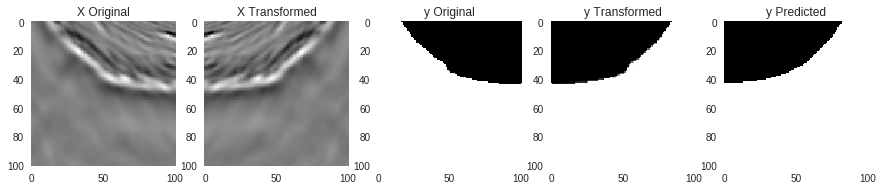

17/09/2018 06:20:20 - SaltNet - INFO - train Mean IOU: 0.7244, Mean Acc: 0.9423, Best Val IOU: 0.7180 at epoch 24
17/09/2018 06:20:34 - SaltNet - INFO - val Mean IOU: 0.7150, Mean Acc: 0.9449, Best Val IOU: 0.7180 at epoch 24
17/09/2018 06:20:34 - SaltNet - INFO - Epoch 25/300
17/09/2018 06:20:34 - SaltNet - INFO - --------------------
17/09/2018 06:22:14 - SaltNet - INFO - Epoch total Loss: 0.2007, Epoch loss_1: 0.1562, Epoch loss_2: 0.0444, Batch IOU: 0.7937, Batch Acc: 0.9589 at iter 2450, epoch 25, Time: 92m 23s


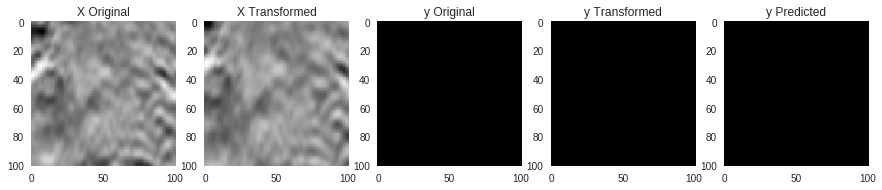

17/09/2018 06:23:55 - SaltNet - INFO - Epoch total Loss: 0.1911, Epoch loss_1: 0.1484, Epoch loss_2: 0.0427, Batch IOU: 0.7125, Batch Acc: 0.9665 at iter 2500, epoch 25, Time: 94m 3s


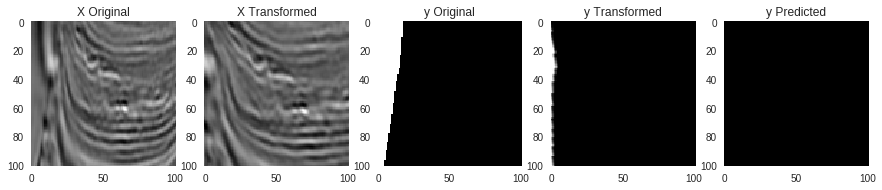

17/09/2018 06:23:56 - SaltNet - INFO - train Mean IOU: 0.7301, Mean Acc: 0.9440, Best Val IOU: 0.7180 at epoch 25
17/09/2018 06:24:10 - SaltNet - INFO - val Mean IOU: 0.7153, Mean Acc: 0.9435, Best Val IOU: 0.7180 at epoch 25
17/09/2018 06:24:10 - SaltNet - INFO - Epoch 26/300
17/09/2018 06:24:10 - SaltNet - INFO - --------------------
17/09/2018 06:24:10 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master b573cd2] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 698 bytes | 698.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   fe81099..b573cd2  master -> master


17/09/2018 06:26:09 - SaltNet - INFO - Epoch total Loss: 0.1947, Epoch loss_1: 0.1480, Epoch loss_2: 0.0467, Batch IOU: 0.7469, Batch Acc: 0.9588 at iter 2550, epoch 26, Time: 96m 18s


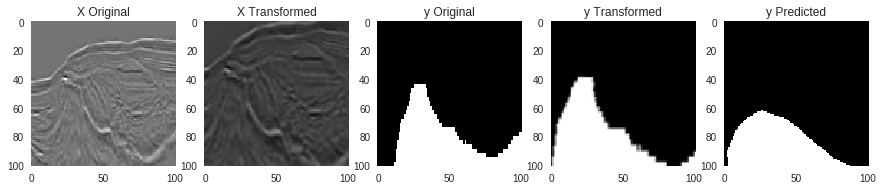

17/09/2018 06:27:50 - SaltNet - INFO - Epoch total Loss: 0.2015, Epoch loss_1: 0.1553, Epoch loss_2: 0.0463, Batch IOU: 0.7094, Batch Acc: 0.9511 at iter 2600, epoch 26, Time: 97m 59s


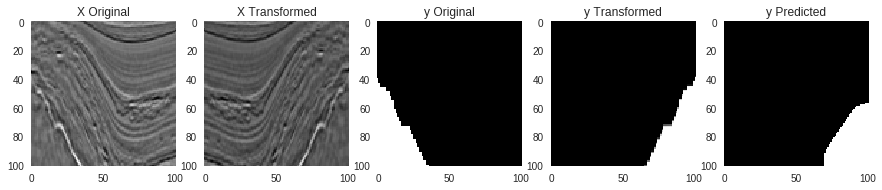

17/09/2018 06:27:52 - SaltNet - INFO - train Mean IOU: 0.7145, Mean Acc: 0.9422, Best Val IOU: 0.7180 at epoch 26
17/09/2018 06:28:05 - SaltNet - INFO - val Mean IOU: 0.7159, Mean Acc: 0.9442, Best Val IOU: 0.7180 at epoch 26
17/09/2018 06:28:05 - SaltNet - INFO - Epoch 27/300
17/09/2018 06:28:05 - SaltNet - INFO - --------------------
17/09/2018 06:29:46 - SaltNet - INFO - Epoch total Loss: 0.2014, Epoch loss_1: 0.1584, Epoch loss_2: 0.0430, Batch IOU: 0.6344, Batch Acc: 0.8939 at iter 2650, epoch 27, Time: 99m 54s


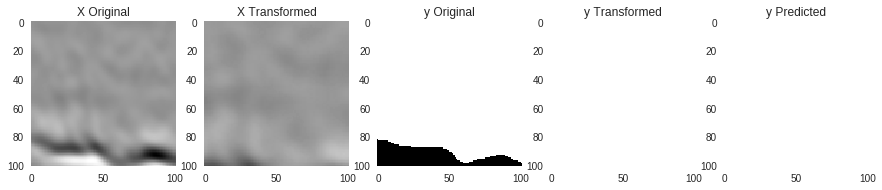

17/09/2018 06:31:27 - SaltNet - INFO - Epoch total Loss: 0.2006, Epoch loss_1: 0.1564, Epoch loss_2: 0.0442, Batch IOU: 0.6469, Batch Acc: 0.9513 at iter 2700, epoch 27, Time: 101m 35s


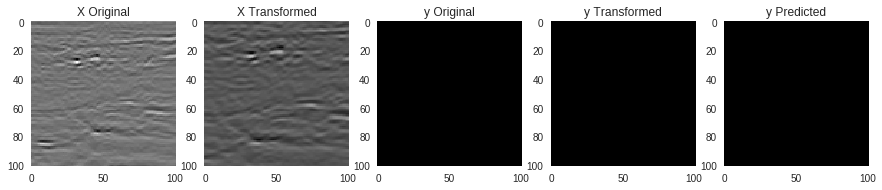

17/09/2018 06:31:28 - SaltNet - INFO - train Mean IOU: 0.7236, Mean Acc: 0.9433, Best Val IOU: 0.7180 at epoch 27
17/09/2018 06:31:42 - SaltNet - INFO - val Mean IOU: 0.7149, Mean Acc: 0.9445, Best Val IOU: 0.7180 at epoch 27
17/09/2018 06:31:42 - SaltNet - INFO - Epoch 28/300
17/09/2018 06:31:42 - SaltNet - INFO - --------------------
17/09/2018 06:31:42 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 6c8fce6] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 720 bytes | 720.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   b573cd2..6c8fce6  master -> master


17/09/2018 06:33:39 - SaltNet - INFO - Epoch total Loss: 0.1933, Epoch loss_1: 0.1496, Epoch loss_2: 0.0437, Batch IOU: 0.6875, Batch Acc: 0.9359 at iter 2750, epoch 28, Time: 103m 48s


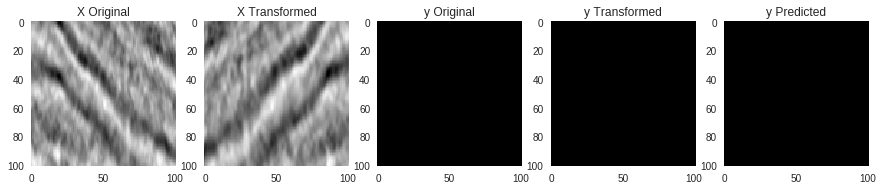

17/09/2018 06:35:21 - SaltNet - INFO - Epoch total Loss: 0.1911, Epoch loss_1: 0.1486, Epoch loss_2: 0.0424, Batch IOU: 0.7344, Batch Acc: 0.9404 at iter 2800, epoch 28, Time: 105m 29s


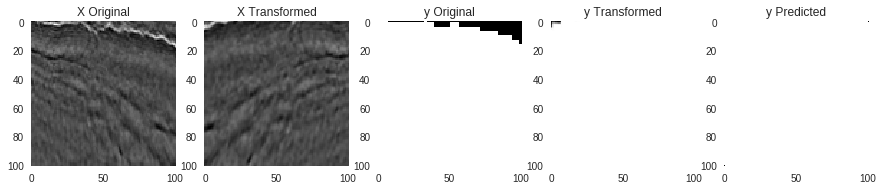

17/09/2018 06:35:22 - SaltNet - INFO - train Mean IOU: 0.7244, Mean Acc: 0.9452, Best Val IOU: 0.7180 at epoch 28
17/09/2018 06:35:36 - SaltNet - INFO - val Mean IOU: 0.7189, Mean Acc: 0.9450, Best Val IOU: 0.7180 at epoch 28
17/09/2018 06:35:36 - SaltNet - INFO - ['../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-1-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-2-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-3-Of-4', '../salt_net/Unet_res34_focal_loss_se_2018_09_17_10_56_13.ckp-chunk-4-Of-4']
17/09/2018 06:35:36 - SaltNet - INFO - Best Val Mean IOU so far: 0.7188749999999999


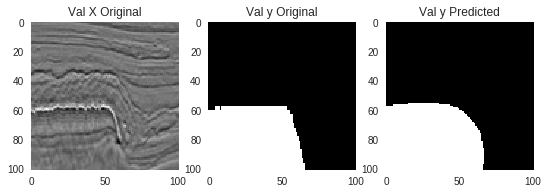

17/09/2018 06:35:37 - SaltNet - INFO - Epoch 29/300
17/09/2018 06:35:37 - SaltNet - INFO - --------------------
17/09/2018 06:37:17 - SaltNet - INFO - Epoch total Loss: 0.1896, Epoch loss_1: 0.1444, Epoch loss_2: 0.0452, Batch IOU: 0.7063, Batch Acc: 0.9364 at iter 2850, epoch 29, Time: 107m 26s


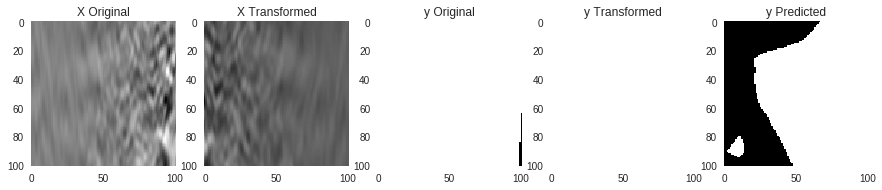

17/09/2018 06:38:59 - SaltNet - INFO - Epoch total Loss: 0.1974, Epoch loss_1: 0.1530, Epoch loss_2: 0.0444, Batch IOU: 0.7250, Batch Acc: 0.9606 at iter 2900, epoch 29, Time: 109m 7s


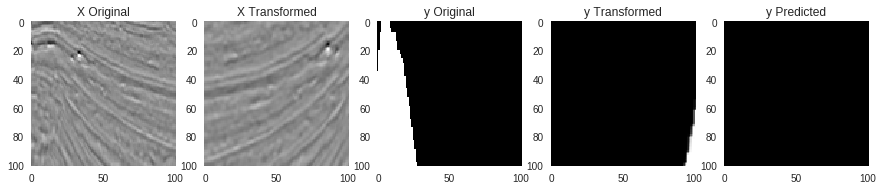

17/09/2018 06:39:00 - SaltNet - INFO - train Mean IOU: 0.7211, Mean Acc: 0.9423, Best Val IOU: 0.7189 at epoch 29
17/09/2018 06:39:14 - SaltNet - INFO - val Mean IOU: 0.7173, Mean Acc: 0.9430, Best Val IOU: 0.7189 at epoch 29
17/09/2018 06:39:14 - SaltNet - INFO - Epoch 30/300
17/09/2018 06:39:14 - SaltNet - INFO - --------------------
17/09/2018 06:39:14 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 1f07050] Pushing logs to git
 1 file changed, 15 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 745 bytes | 745.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   6c8fce6..1f07050  master -> master


17/09/2018 06:41:14 - SaltNet - INFO - Epoch total Loss: 0.2025, Epoch loss_1: 0.1571, Epoch loss_2: 0.0454, Batch IOU: 0.7656, Batch Acc: 0.9627 at iter 2950, epoch 30, Time: 111m 23s


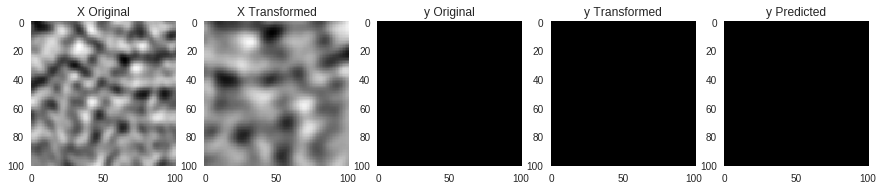

17/09/2018 06:42:56 - SaltNet - INFO - Epoch total Loss: 0.1996, Epoch loss_1: 0.1544, Epoch loss_2: 0.0452, Batch IOU: 0.7031, Batch Acc: 0.9402 at iter 3000, epoch 30, Time: 113m 4s


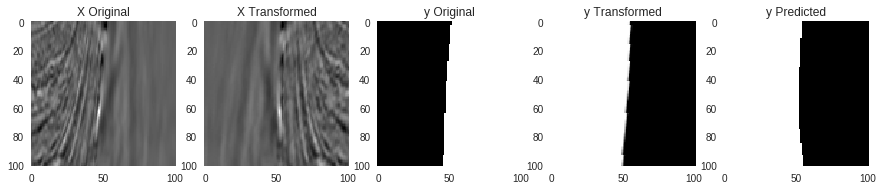

17/09/2018 06:42:57 - SaltNet - INFO - train Mean IOU: 0.7200, Mean Acc: 0.9425, Best Val IOU: 0.7189 at epoch 30
17/09/2018 06:43:11 - SaltNet - INFO - val Mean IOU: 0.7100, Mean Acc: 0.9405, Best Val IOU: 0.7189 at epoch 30
17/09/2018 06:43:11 - SaltNet - INFO - Epoch 31/300
17/09/2018 06:43:11 - SaltNet - INFO - --------------------
17/09/2018 06:44:51 - SaltNet - INFO - Epoch total Loss: 0.1898, Epoch loss_1: 0.1480, Epoch loss_2: 0.0418, Batch IOU: 0.6937, Batch Acc: 0.9254 at iter 3050, epoch 31, Time: 115m 0s


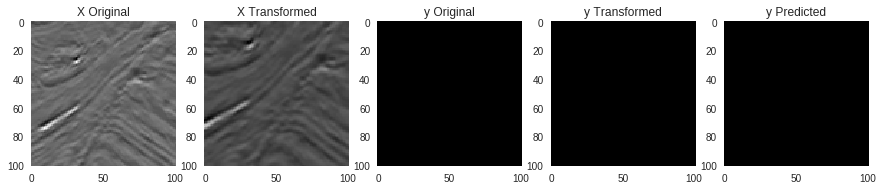

17/09/2018 06:46:33 - SaltNet - INFO - Epoch total Loss: 0.2005, Epoch loss_1: 0.1562, Epoch loss_2: 0.0443, Batch IOU: 0.7375, Batch Acc: 0.9356 at iter 3100, epoch 31, Time: 116m 41s


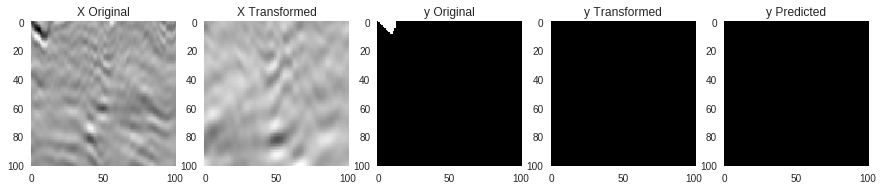

17/09/2018 06:46:34 - SaltNet - INFO - train Mean IOU: 0.7248, Mean Acc: 0.9428, Best Val IOU: 0.7189 at epoch 31
17/09/2018 06:46:48 - SaltNet - INFO - val Mean IOU: 0.7143, Mean Acc: 0.9433, Best Val IOU: 0.7189 at epoch 31
17/09/2018 06:46:48 - SaltNet - INFO - Epoch 32/300
17/09/2018 06:46:48 - SaltNet - INFO - --------------------
17/09/2018 06:46:48 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 74c40f3] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 720 bytes | 720.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   1f07050..74c40f3  master -> master


17/09/2018 06:48:46 - SaltNet - INFO - Epoch total Loss: 0.1933, Epoch loss_1: 0.1493, Epoch loss_2: 0.0440, Batch IOU: 0.7656, Batch Acc: 0.9390 at iter 3150, epoch 32, Time: 118m 54s


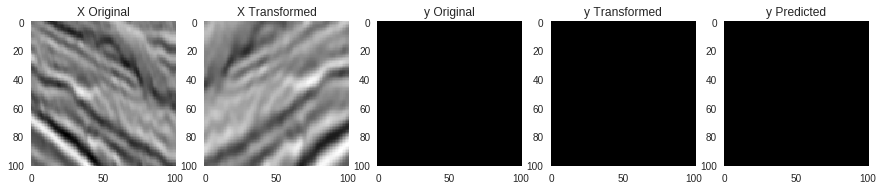

17/09/2018 06:50:27 - SaltNet - INFO - Epoch total Loss: 0.1999, Epoch loss_1: 0.1542, Epoch loss_2: 0.0457, Batch IOU: 0.6281, Batch Acc: 0.9379 at iter 3200, epoch 32, Time: 120m 35s


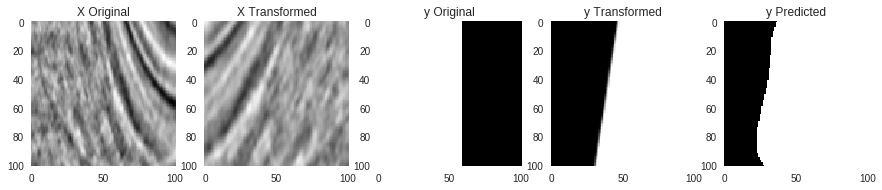

17/09/2018 06:50:28 - SaltNet - INFO - train Mean IOU: 0.7187, Mean Acc: 0.9418, Best Val IOU: 0.7189 at epoch 32
17/09/2018 06:50:42 - SaltNet - INFO - val Mean IOU: 0.7143, Mean Acc: 0.9423, Best Val IOU: 0.7189 at epoch 32
17/09/2018 06:50:42 - SaltNet - INFO - Epoch 33/300
17/09/2018 06:50:42 - SaltNet - INFO - --------------------
17/09/2018 06:52:23 - SaltNet - INFO - Epoch total Loss: 0.1888, Epoch loss_1: 0.1455, Epoch loss_2: 0.0433, Batch IOU: 0.7312, Batch Acc: 0.9649 at iter 3250, epoch 33, Time: 122m 31s


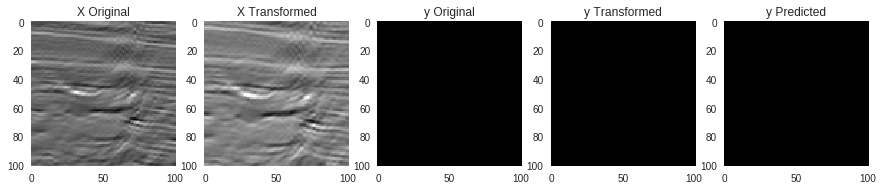

17/09/2018 06:54:04 - SaltNet - INFO - Epoch total Loss: 0.1897, Epoch loss_1: 0.1464, Epoch loss_2: 0.0433, Batch IOU: 0.6875, Batch Acc: 0.9378 at iter 3300, epoch 33, Time: 124m 12s


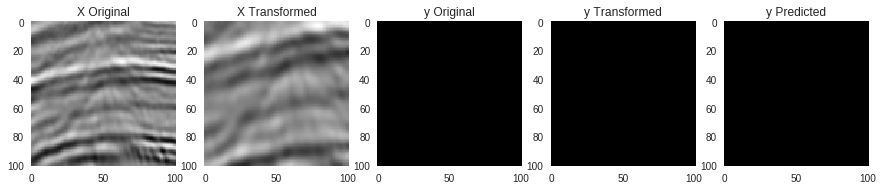

17/09/2018 06:54:05 - SaltNet - INFO - train Mean IOU: 0.7239, Mean Acc: 0.9452, Best Val IOU: 0.7189 at epoch 33
17/09/2018 06:54:19 - SaltNet - INFO - val Mean IOU: 0.7169, Mean Acc: 0.9443, Best Val IOU: 0.7189 at epoch 33
17/09/2018 06:54:19 - SaltNet - INFO - Epoch 34/300
17/09/2018 06:54:19 - SaltNet - INFO - --------------------
17/09/2018 06:54:19 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 4fe4b73] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 704 bytes | 704.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   74c40f3..4fe4b73  master -> master
Epoch    33: reducing learning rate of group 0 to 5.0000e-06.


17/09/2018 06:56:17 - SaltNet - INFO - Epoch total Loss: 0.1945, Epoch loss_1: 0.1494, Epoch loss_2: 0.0450, Batch IOU: 0.8500, Batch Acc: 0.9646 at iter 3350, epoch 34, Time: 126m 25s


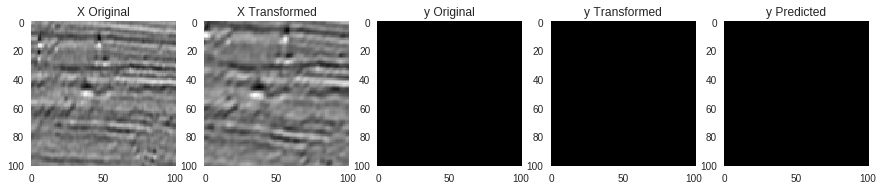

17/09/2018 06:57:58 - SaltNet - INFO - Epoch total Loss: 0.1937, Epoch loss_1: 0.1489, Epoch loss_2: 0.0448, Batch IOU: 0.7937, Batch Acc: 0.9621 at iter 3400, epoch 34, Time: 128m 7s


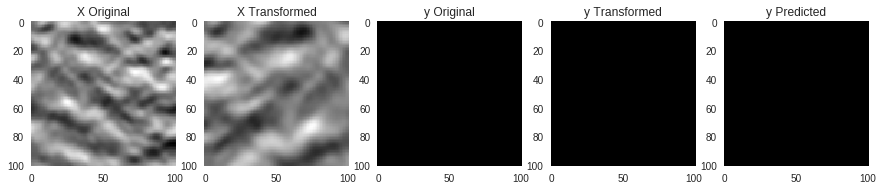

17/09/2018 06:57:59 - SaltNet - INFO - train Mean IOU: 0.7212, Mean Acc: 0.9436, Best Val IOU: 0.7189 at epoch 34
17/09/2018 06:58:13 - SaltNet - INFO - val Mean IOU: 0.7149, Mean Acc: 0.9414, Best Val IOU: 0.7189 at epoch 34
17/09/2018 06:58:13 - SaltNet - INFO - Epoch 35/300
17/09/2018 06:58:13 - SaltNet - INFO - --------------------
17/09/2018 06:59:54 - SaltNet - INFO - Epoch total Loss: 0.2106, Epoch loss_1: 0.1658, Epoch loss_2: 0.0448, Batch IOU: 0.7312, Batch Acc: 0.9233 at iter 3450, epoch 35, Time: 130m 2s


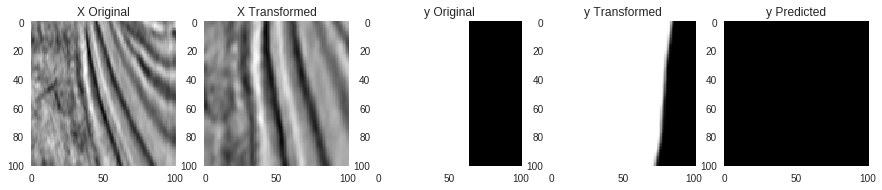

17/09/2018 07:01:35 - SaltNet - INFO - Epoch total Loss: 0.2016, Epoch loss_1: 0.1570, Epoch loss_2: 0.0446, Batch IOU: 0.7313, Batch Acc: 0.9552 at iter 3500, epoch 35, Time: 131m 44s


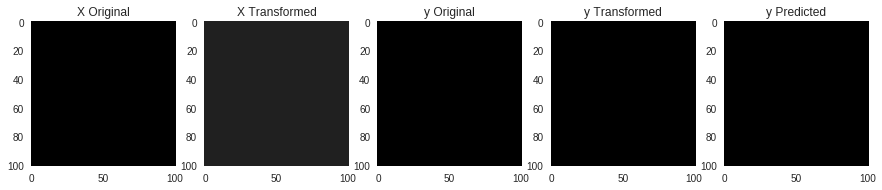

17/09/2018 07:01:36 - SaltNet - INFO - train Mean IOU: 0.7262, Mean Acc: 0.9414, Best Val IOU: 0.7189 at epoch 35
17/09/2018 07:01:50 - SaltNet - INFO - val Mean IOU: 0.7111, Mean Acc: 0.9431, Best Val IOU: 0.7189 at epoch 35
17/09/2018 07:01:50 - SaltNet - INFO - Epoch 36/300
17/09/2018 07:01:50 - SaltNet - INFO - --------------------
17/09/2018 07:01:50 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master 4354872] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 708 bytes | 708.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   4fe4b73..4354872  master -> master


17/09/2018 07:03:46 - SaltNet - INFO - Epoch total Loss: 0.1931, Epoch loss_1: 0.1506, Epoch loss_2: 0.0425, Batch IOU: 0.6344, Batch Acc: 0.9569 at iter 3550, epoch 36, Time: 133m 54s


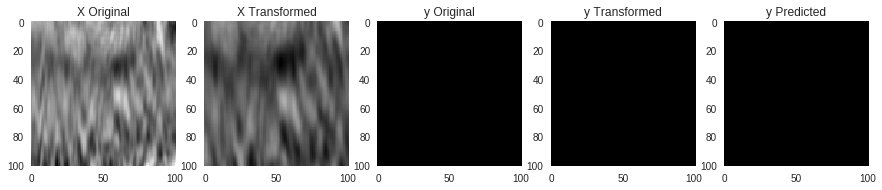

17/09/2018 07:05:27 - SaltNet - INFO - Epoch total Loss: 0.1923, Epoch loss_1: 0.1496, Epoch loss_2: 0.0426, Batch IOU: 0.7469, Batch Acc: 0.9383 at iter 3600, epoch 36, Time: 135m 35s


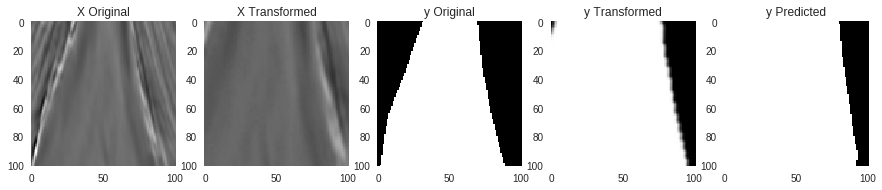

17/09/2018 07:05:28 - SaltNet - INFO - train Mean IOU: 0.7282, Mean Acc: 0.9460, Best Val IOU: 0.7189 at epoch 36


KeyboardInterrupt: ignored

In [55]:
#saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
saltnet = UResNet(pretrained=True)
loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.SGD(saltnet.parameters(), lr=0.005)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=0.0001)

model_save_name = f'../salt_net/Unet_res34_focal_loss_se_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=300, print_every=50, save_model_every=20, save_log_every=2, log=log, loss1_weight=1.0, loss2_weight=0.1)

On branch master
Your branch is ahead of 'origin/master' by 3 commits.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   logs/SaltNet_2018_09_16_19h.log

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	Unet_res34_focal_loss_se_2018_09_16_21_11_11.ckp-chunk-1-Of-10
	Unet_res34_focal_loss_se_2018_09_16_21_11_11.ckp-chunk-10-Of-10
	Unet_res34_focal_loss_se_2018_09_16_21_11_11.ckp-chunk-2-Of-10
	Unet_res34_focal_loss_se_2018_09_16_21_11_11.ckp-chunk-3-Of-10
	Unet_res34_focal_loss_se_2018_09_16_21_11_11.ckp-chunk-4-Of-10
	Unet_res34_focal_loss_se_2018_09_16_21_11_11.ckp-chunk-5-Of-10
	Unet_res34_focal_loss_se_2018_09_16_21_11_11.ckp-chunk-6-Of-10
	Unet_res34_focal_loss_se_2018_09_16_21_11_11.ckp-chunk-7-Of-10
	Unet_res34_focal_loss_se_2018_09_16_21_11_11.ckp-chunk-8-Of-10
	Une

In [ ]:
## Fine tune

## Fine Tune

In [ ]:
log.info('Fine tune Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34 net. Use loss_lovasz_hinge loss only.')

In [ ]:
model_config = '''
p = Pipeline_Salt(min_mask_ratio=0.5)
p.skew(probability=1, magnitude=0.5)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_random(probability=0.5, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')

saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
model_file_suffix = "Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])

#saltnet = loaded_model
loss_fn_bce = nn.BCEWithLogitsLoss()
#loss_focal = FocalLoss(0.25, 2.5, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

model_save_name = f'../salt_net/Unet_lovasz_loss_se_finetune2_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=60, print_every=50, save_model_every=20, save_log_every=2, log=log, loss1_weight=0.0, loss2_weight=1.0)

'''

In [ ]:
log.info(model_config)

In [ ]:
cd ../salt_net

In [ ]:
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
model_file_suffix = "Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])

In [ ]:
#saltnet = loaded_model
loss_fn_bce = nn.BCEWithLogitsLoss()
#loss_focal = FocalLoss(0.25, 2.5, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

model_save_name = f'../salt_net/Unet_lovasz_loss_se_finetune2_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=44, save_model_every=20, save_log_every=2, log=log, loss1_weight=0.0, loss2_weight=1.0)

In [ ]:
2879//32

In [ ]:
# fine tune 3

In [ ]:
log.info('Fine tune Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34 net. Remove hard images. Use loss_lovasz_hinge and bce loss')

In [ ]:
model_config = '''
p = Pipeline_Salt(min_mask_ratio=0.5)
p.skew(probability=1, magnitude=0.5)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_random(probability=0.5, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')

saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
model_file_suffix = "Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])

#saltnet = loaded_model
loss_fn_bce = nn.BCEWithLogitsLoss()
#loss_focal = FocalLoss(0.25, 2.5, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_se_finetune2_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=50, save_model_every=20, save_log_every=2, log=log, loss1_weight=1.0, loss2_weight=1.0)

'''

In [ ]:
log.info(model_config)

In [ ]:
cd ../salt_net

In [ ]:
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
model_file_suffix = "Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])

In [ ]:
#saltnet = loaded_model
loss_fn_bce = nn.BCEWithLogitsLoss()
#loss_focal = FocalLoss(0.25, 2.5, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_se_finetune3_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=44, save_model_every=20, save_log_every=2, log=log, loss1_weight=1.0, loss2_weight=1.0)

In [ ]:
# fine tune 4

In [ ]:
log.info('Fine tune Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34 net. Remove hard images. Use lovasz loss only with SGD. Less data aug')

In [ ]:
model_config = '''
p = Pipeline_Salt(min_mask_ratio=0.1)
#p.skew(probability=1, magnitude=0.5)
#p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
#p.zoom(probability=0.5, min_factor=1.05, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_random(probability=0.5, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')

#weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_sample_weight.values, depth_train.shape[0])

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': True}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

#saltnet = loaded_model
#loss_fn_bce = nn.BCEWithLogitsLoss()
loss_focal = FocalLoss(0.25, 2.0, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.SGD(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

model_save_name = f'../salt_net/Unet_lovasz_loss_se_finetune6_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_focal, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=300, print_every=44, save_model_every=20, save_log_every=2, log=log, loss1_weight=0.0, loss2_weight=1.)

'''

In [ ]:
log.info(model_config)

In [ ]:
p = Pipeline_Salt(min_mask_ratio=0.1)
#p.skew(probability=1, magnitude=0.5)
#p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
#p.zoom(probability=0.5, min_factor=1.05, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_random(probability=0.5, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')

#weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_sample_weight.values, depth_train.shape[0])

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': True}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

In [ ]:
cd ../salt_net

In [ ]:
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
model_file_suffix = "Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])

In [ ]:
!git status

In [ ]:
#saltnet = loaded_model
#loss_fn_bce = nn.BCEWithLogitsLoss()
loss_focal = FocalLoss(0.25, 2.0, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.SGD(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

model_save_name = f'../salt_net/Unet_lovasz_loss_se_finetune6_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_focal, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=300, print_every=44, save_model_every=20, save_log_every=2, log=log, loss1_weight=0.0, loss2_weight=1.)

## Load Trained Model

In [ ]:
loaded_model = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)

In [ ]:
cd ../salt_net

In [ ]:
model_file_suffix = "Unet_bce_loss_lovasz_loss_se_2018_09_14_12_35_12.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
loaded_model.load_state_dict(model_state_dict['model'])

### Make Predictions on validation set

### Set model to evaluation mode

In [ ]:
loaded_model.eval()
assert loaded_model.training == False

In [ ]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128), batch_size=16)

In [ ]:
if torch.cuda.is_available():
    loaded_model.cuda()

In [ ]:
y_val_pred = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred.append(loaded_model(X_val_batch))
y_val_pred = torch.cat(y_val_pred)

In [ ]:
p = Pipeline_Salt()
p.flip_left_right(probability=1)
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128, out_ch=1,
                           transform=p.torch_transform()), batch_size=16)
y_val_pred_flip = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred_flip.append(loaded_model(X_val_batch))
y_val_pred_flip = torch.cat(y_val_pred_flip)
y_val_pred_flip = torch.flip(y_val_pred_flip,[2])

In [ ]:
y_val_pred_ens = torch.where(y_val_pred.abs() > y_val_pred_flip.abs(), y_val_pred, y_val_pred_flip)

In [ ]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred.gt(0), y_val.squeeze())

In [ ]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred_ens.gt(-0.1115), y_val.squeeze())

In [ ]:
MASK_CUTOFF = -0.1115

In [ ]:
for i in np.r_[-0.15:-0.08:21j]:
  print(i)
  y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred_ens.gt(i), y_val.squeeze())

In [ ]:
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img, out_size=128), batch_size=16)
y_train_pred = []

with torch.no_grad():
    for X_train_batch, y_train_batch, depth_train_batch, X_train_id_batch in train_dataLoader:
        y_train_pred.append(loaded_model(X_train_batch))
y_train_pred = torch.cat(y_train_pred)

In [ ]:
for i in range(10):
    rand_id = np.random.choice(X_val_id_batch)
    print(f'Image ID: {rand_id}')
    val_img = X_val[rand_id]/255
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([val_img, val_mask, val_mask_pred], range(3), img_per_line=3)

In [ ]:
for i in range(10):
    rand_id = np.random.choice(X_train_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_train[rand_id]/255
    mask = y_train[rand_id]
    mask_pred = y_train_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([img, mask, mask_pred], range(3), img_per_line=3)

In [ ]:
ZERO_MASK_CUTOFF = 0
MASK_CUTOFF = -0.1115

In [ ]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

In [ ]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred.gt(0.), y_val.squeeze())

In [ ]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_val, y_val_pred_ens.gt(MASK_CUTOFF), y_val.squeeze()), y_val.squeeze()))

In [ ]:
range(0, 300, 10)[np.argmax(results)]

In [ ]:
results

In [ ]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

In [ ]:
y_train_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_train, y_train_pred.gt(MASK_CUTOFF), y_train.squeeze())

In [ ]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_train, y_train_pred.gt(MASK_CUTOFF), y_train.squeeze()), y_train.squeeze()))

In [ ]:
range(0, 3000, 10)[np.argmax(results)]

## Make predictions on test set

In [ ]:
#test_dataLoader = DataLoader(SaltDataset(np_test[:10], None, depth_test, X_train_mean_img), batch_size=4)
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128), batch_size=16)

In [ ]:
y_test_pred_raw = []
with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_raw.append(loaded_model(X_test_batch))
y_test_pred = torch.cat(y_test_pred_raw)

### Show segmentation masks for a few images

In [ ]:
for i in range(10):
    rand_id = np.random.choice(X_test_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_test[rand_id]/255
    mask_pred = y_test_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([img, mask_pred], range(2))

### Adjust predictions

In [ ]:
 ZERO_MASK_CUTOFF = 0
 MASK_CUTOFF = -0.1115

In [ ]:
y_test_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_test, y_test_pred.gt(MASK_CUTOFF))

### Encode predictions using RLE(Run Length Encoding) method

In [ ]:
y_test_pred_rle = rle_encoder3d(y_test_pred_adj)

In [ ]:
y_test_pred_adj.shape

In [ ]:
df_test_rle = pd.DataFrame(index=misc_data['np_test_ids'], data=y_test_pred_rle).reset_index()

In [ ]:
df_test_rle.columns = ['id', 'rle_mask']

In [ ]:
df_test_rle[df_test_rle.rle_mask==''].shape

In [ ]:
df_test_rle.shape

In [ ]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)

In [ ]:
ls

In [ ]:
from google.colab import files


In [ ]:
files.download('submission_2018_09_15_00_18_33.csv') 

In [ ]:
import numpy as np

In [ ]:
p = Pipeline_Salt()
p.flip_left_right(probability=1)
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128, out_ch=1,
                           transform=p.torch_transform()), batch_size=16)
y_test_pred_flip = []

with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_flip.append(loaded_model(X_test_batch))
y_test_pred_flip = torch.cat(y_test_pred_flip)
y_test_pred_flip = torch.flip(y_test_pred_flip,[2])

In [ ]:

y_test_pred = torch.where(y_test_pred.abs() > y_test_pred_flip.abs(), y_test_pred, y_test_pred_flip)

In [ ]:
y_test_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_test, y_test_pred.gt(MASK_CUTOFF))


In [ ]:
MASK_CUTOFF

In [ ]:
y_test_pred_rle = rle_encoder3d(y_test_pred_adj)

In [ ]:
y_test_pred_adj.shape

In [ ]:
df_test_rle = pd.DataFrame(index=misc_data['np_test_ids'], data=y_test_pred_rle).reset_index()

In [ ]:
df_test_rle.columns = ['id', 'rle_mask']

In [ ]:
df_test_rle[df_test_rle.rle_mask==''].shape

In [ ]:
df_test_rle.shape

In [ ]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)

In [ ]:
ls

In [ ]:
from google.colab import files


In [ ]:
files.download('submission_2018_09_15_17_45_21.csv') 